# Cowboy results for X

***Add notes about your experiment here.***

*NB* requires a kernel with pycorn.

In [1]:
import glob
from datetime import date; today=date.today().strftime('%Y%m%d')[2:]; print(f'Today: {today}')
# import warnings; warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
import sys, os; sys.path.append(os.getcwd())
from wetlab_utils import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns; sns.set_theme(
    context='talk', 
    palette='colorblind',
    style='ticks',
    rc={'axes.spines.right':False, 'axes.spines.top':False}
)

Today: 240304


## ECHO cloning


`eblocks_plates`: dictionary containing paths to `.xlsx` files from IDT eBlocks order(s).
- If the IDT order spreadsheet is passed unmodified, and a set of vectors is indicated, then the ECHO transfer protocol will include cloning of every eBlock into every vector.
- If more complex cloning combinatorics is desired, include a `Vector` column in the spreadhseet to specify the entry vector for each eBlock. 

***If not using the ECHO generator function, `echo_df` should at a minimum contain the following columns:***
   - `Name`: the name of your design.
   - `Destination Well`: the destination well of the transfer.
   - `Destination Plate Name`: 96w expression plate identifier.
   - `eblock`: the eBlock sequence.
   - `Vector`: the GGA entry vector ID, e.g. `LM0627`.

In [2]:
eblock_plates  = {
    1:'/home/bwicky/for/db/DB_combined_eblocks.xlsx'
}

echo_df, mm_df = gen_echo_transfers(
    eblock_plates,
    vectors=['SK0003', 'LM0671'],
    vector_stock_conc=[61, 186],
    path_to_vectors='/software/lab/johnbercow/entry_vectors/',
)
print(f'Number of GGA reactions: {len(echo_df.dropna())}')
mm_df

Number of GGA reactions: 191


per_rxn_uL     tot_uL
H2O                      0.107742  19.657709
T4 buffer                     0.1  18.245109
SK0003 @ 61 ng/uL         0.26141  47.694463
BsaI_HFv2 (NEB#R3733L)       0.06  10.947066
T4 ligase (NEB#M0202L)        0.1  18.245109
Add [SK0003] MM to       P24, P23  57.394728
                                            
H2O                      0.285574  49.533073
T4 buffer                     0.1  17.345109
LM0671 @ 186 ng/uL       0.083578  14.496731
BsaI_HFv2 (NEB#R3733L)       0.06  10.407066
T4 ligase (NEB#M0202L)        0.1  17.345109
Add [LM0671] MM to       P22, P21  54.563544

## Expression/purification parameters
- `oligomers`: whether or not your designs are oligomers (if `True`, a column `n_chains` needs to be specified in `echo_df`).
- `culture_vol`: culture volume, formated as a string `AxB` where `B` is the volume of one culture (in mL), and `A` the number of consolidated cultures.
- `culture_time`: time between inocculation and harvest, in hours.
- `culture_temp`: temperature during growth/expression, in degree Celsius.
- `sec_column`: column used for SEC, e.g. `S75_5-150`.
- `sec_buffer`: buffer used for SEC.
- `sec_buffer_pH`: the pH of the SEC buffer. 
- `sec_instrument`: the instrument used for SEC. Must be either `akta` or `hplc`.
- `sec_calibration`: instrument and column-specific calibration file (`.json` format)
- `sec_traces`: dictionary of lists of paths to exported SEC traces. 
    - `AKTA` data structure should be `/path_to_your_run/*.zip`. The list should contain paths to the individual `.zip` files.
    - `HPLC` data structure should be `/path_to_your_run/trace_folders/*.CSV`. The list should contain paths to the individual *trace folders*, NOT the individual `.CSV` files. The folder containing the individual trace folders should also contain the `fractions.csv` file containing the mapping between traces and fractions.

In [3]:
oligomers       = False
culture_vol     = '4x1'
culture_time    = 20
culture_temp    = 37
sec_column      = 'S75_5-150'
sec_buffer      = 'PBS'
sec_buffer_pH   = 7.4
sec_instrument  = 'hplc'
sec_calibration = '/home/bwicky/sec/calibrations/240115_S200mini_HPLC.json'
sec_traces      = {
    1:glob.glob('/net/expdata/HPLC/_HAL9000/DavidB/2024_01_15_192samples_S200_PBS/*')
}

print(f'Number of SEC traces: {np.sum([len(v) for v in sec_traces.values()])}')
print('\n'.join([f'> {k}: {len(v)}' for k, v in sec_traces.items()]))

Number of SEC traces: 193
> 1: 193


### Add information to dataframe

If you are cloning into non-standard entry vectors, change the path to their `.fa` files.

In [4]:
# Clone.
echo_df['plasmid_seq'] = echo_df.apply(
    clone, 
    path_to_vectors='/software/lab/johnbercow/entry_vectors/',
    axis=1,
)
echo_df['ORF'] = echo_df.apply(coding_seq, axis=1)

# Protparam.
echo_df = protparam(echo_df, oligomers, sec_buffer_pH)

# Expression parameters.
echo_df['culture_vol'] = float(culture_vol.split('x')[0]) * float(culture_vol.split('x')[1])
echo_df['culture_time'] = culture_time
echo_df['culture_temp'] = culture_temp

# Purification parameters.
echo_df['sec_instrument'] = sec_instrument
echo_df['sec_column'] = sec_column
echo_df['sec_buffer'] = sec_buffer  

# OPTIONAL: define a category for later comparisons (e.g. designs made using different methods).
echo_df['category'] = echo_df['Destination Plate Name'].astype(str)
echo_df.category.value_counts()

1    96
2    95
Name: category, dtype: int64

### Process SEC chromatograms

*NB*: 205 nm may be used instead of 280 nm for protein quantification, however this option is poorly validated.

In [6]:
# %%capture

wl = 280 # wavelength used for all downstream data processing.

parsed_chromatograms = {}
for run, traces in sec_traces.items():
    parsed_chromatograms[run] = parse_chromatograms(traces, instrument=sec_instrument)
    
sec_data = {}
for run, parsed_chroma in parsed_chromatograms.items():
    sec_data[run] = process_sec_data(parsed_chroma, wavelength=wl)

### Map traces to wells

***CAUTION:*** make sure to validate your mapping (both wells AND destination plates), especially if you had to e.g. restart you SEC run (indices may have shifted!). 

Check that the size of the resulting dataframe matches the number of samples you injected.

In [7]:
sec_df = pd.DataFrame()
for run, sec_d in sec_data.items():
    
    w96 = [str(p) + '_' + r + str(c) for p in range(1, 10) for r in 'ABCDEFGH' for c in range(1, 13)]

    if sec_instrument == 'akta':
        
        akta2well = {i+1:w for i, w in enumerate(w96)}    
        sec_d['well_id'] = sec_d['trace_id'].map(akta2well)
        sec_d['Destination Plate Name'] = sec_d['well_id'].apply(lambda x: int(x.split('_')[0]))
        sec_d['Destination Well'] = sec_d['well_id'].apply(lambda x: x.split('_')[1])
        
    if sec_instrument == 'hplc':
        
        drawer2plate = {'D1F':1, 'D1B':2, 'D2F':3, 'D2B':4, 'D3F':5, 'D3B':6, 'D4F':7, 'D4B':8}
        sec_d['Destination Plate Name'] = sec_d['trace_id'].apply(lambda x: drawer2plate[x.split('-')[0]])
        sec_d['Destination Well'] = sec_d['trace_id'].apply(lambda x: x.split('-')[1])
        sec_d['well_id'] = sec_d['Destination Plate Name'].astype(str) + '_' + sec_d['Destination Well']
                                                                   
    sec_df = pd.concat([sec_df, sec_d])
    
df = echo_df.merge(
    sec_df, 
    left_on=['Destination Plate Name', 'Destination Well'], 
    right_on=['Destination Plate Name', 'Destination Well'],
).reset_index(drop=True)

len(df)

191

### Add yields and calibrated results to dataframe

In [8]:
df = yields(df) 
df, CI95, CI99 = calibrated_results(df, sec_calibration) 
int_df = df.copy()

## Results overview

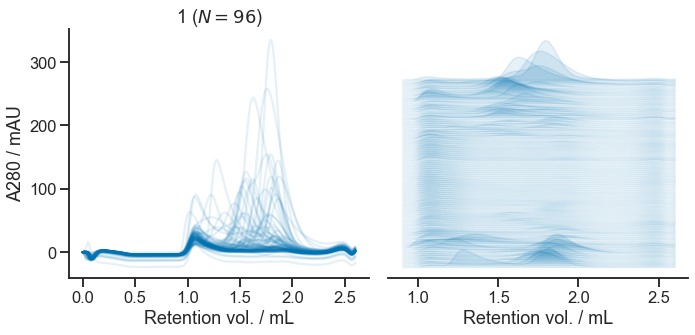

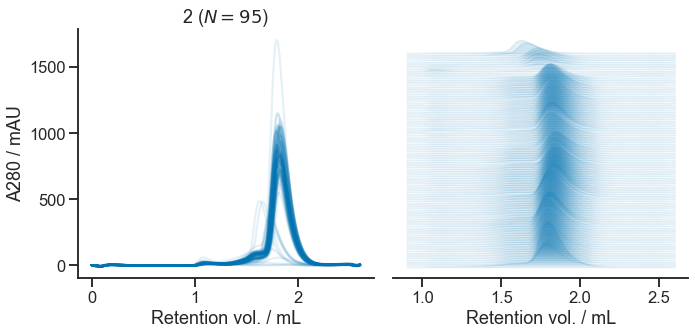

In [10]:
for cat, sel in df.groupby('category'):

    sel.reset_index(inplace=True)

    # Cluster chromatograms. 
    vol_light = np.vstack(sel.loc[:, 'vol_light'].to_numpy())
    Abs_light = np.vstack(sel.loc[:, 'Abs_light'].to_numpy())
    clustered_idx = hierarchy.dendrogram(
            hierarchy.linkage(
            Abs_light, 
            method='average',
            optimal_ordering=True
        ), 
        no_plot=True,
    )['leaves'] # 'leaves' are the re-ordered indices
    
    # Plot.
    delta = np.max([np.max(x) for x in sel.Abs.to_numpy()]) / 20
    fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
    for i, r in sel.iterrows():
        ax[0].plot(r.vol, r.Abs, color='C0', alpha=0.1)
        ax[1].fill_between(
            x=vol_light[clustered_idx[i]],
            y1=Abs_light[clustered_idx[i]] + i*delta,
            y2=i*delta, 
            color='C0',
            alpha=0.1, 
            zorder=i
        )

    ax[0].set(xlabel='Retention vol. / mL', ylabel=f'A280 / mAU')
    ax[1].set(xlabel='Retention vol. / mL', yticks=[])
    ax[1].spines['left'].set_visible(False)
    ax[0].set(title=f'{cat} ($N = {len(sel)}$)')
    plt.tight_layout()
    plt.savefig(f'all_sec_traces_{cat}.png', dpi=300)
    plt.show()

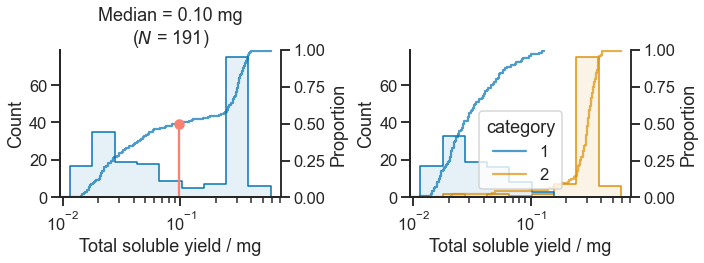

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

sns.histplot(
    data=df, 
    x='tot_yield', 
    stat='count',
    ax=ax[0],
    log_scale=True, 
    element='step', 
    alpha=0.1,
)

ax0 = ax[0].twinx()
ax0.vlines(df.tot_yield.median(), 0, .5, color='salmon')
ax0.scatter(df.tot_yield.median(), .5, color='salmon', zorder=10)
sns.ecdfplot(data=df, x='tot_yield', alpha=0.7, ax=ax0)
ax[0].spines['right'].set_visible(True)
ax[0].set_xlabel('Total soluble yield / mg')
ax[0].set_title(f'Median = {df["tot_yield"].median():.2f} mg\n($N$ = {len(df)})')
          
sns.histplot(
    data=df, 
    x='tot_yield', 
    hue='category',
    stat='count',
    ax=ax[1],
    log_scale=True,
    element='step',
    alpha=0.1,
    legend=False,
)

sns.ecdfplot(
    data=df, 
    x='tot_yield', 
    hue='category', 
    ax=ax[1].twinx(), 
    legend=True,
    alpha=0.7,
)

ax[1].spines['right'].set_visible(True)
ax[1].set_xlabel('Total soluble yield / mg')

plt.tight_layout()
plt.savefig('tot_soluble_yields.png', dpi=300)
plt.show()

## Calibrated results

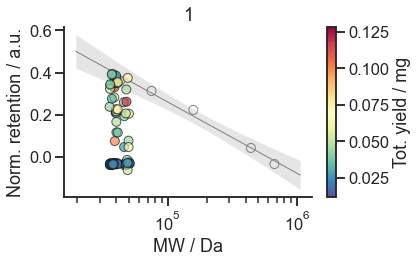

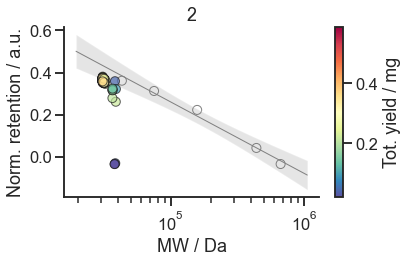

In [12]:
# Get SEC column calibration parameters.
with open(sec_calibration, 'r') as f:
    sec_cal = json.load(f)

Vo, Vc = sec_cal['Vo'], sec_cal['Vc'] 
intercept, slope = sec_cal['intercept'], sec_cal['slope'] 
all_mws = np.hstack([sec_cal['log10mw'], np.log10(df['MW'].to_numpy())])
xs = np.linspace(all_mws.min()-0.2, all_mws.max()+0.2, 100)
    
def Vel2MW(Vel):
        return 10**((((Vel - Vo) / (Vc - Vo)) - intercept) / slope)
    
for c, sel in df.groupby('category'):
    
    # Plot calibration curve and CI.
    plt.scatter(
        [10**x for x in sec_cal['log10mw']], 
        sec_cal['Kav'], 
        edgecolor='grey', 
        linewidth=1, 
        color='None', 
        alpha=1,
    )
    
    plt.plot(
        10**xs, 
        intercept + slope * xs, 
        color='grey', 
        linewidth=1,
    )
    
    plt.fill_between(
        10**xs, 
        CI95[0], 
        CI95[1], 
        color='grey', 
        alpha=0.2, 
        edgecolor=None,
    )

    # Plot data.
    norm = plt.Normalize(sel.tot_yield.min(), sel.tot_yield.max())
    sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)
    
    ax = sns.scatterplot(
        data=sel, 
        x='MW', 
        y='main_peak_norm_retention', 
        hue='tot_yield', 
        palette='Spectral_r', 
        zorder=10, 
        edgecolor='k', 
        linewidth=1, 
        alpha=0.7,
    )
    
    plt.xscale('log')
    plt.xlabel('MW / Da')
    plt.ylabel('Norm. retention / a.u.')
    
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label='Tot. yield / mg')
    plt.title(c)
    plt.tight_layout()
    plt.savefig(f'{c}_against_calibration.png', dpi=300)
    plt.show()

/home/bwicky/.conda/envs/sec/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/bwicky/.conda/envs/sec/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 49.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


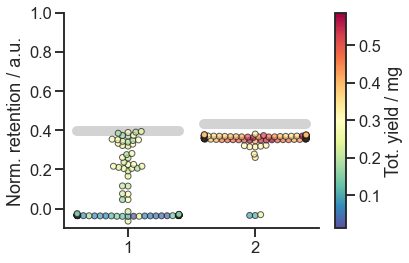

In [13]:
norm = plt.Normalize(df.tot_yield.min(), df.tot_yield.max())
sm = plt.cm.ScalarMappable(cmap='Spectral_r', norm=norm)

sns.boxplot(
    data=df, 
    x='category', 
    y='expected_norm_retention', 
    zorder=0,
    medianprops={'visible': True, 'color': 'lightgrey', 'ls': '-', 'lw': 10},
    whiskerprops={'visible': False},
    showfliers=False,
    showbox=False,
    showcaps=False,
)

ax = sns.swarmplot(
    data=df, 
    x='category', 
    y='main_peak_norm_retention', 
    hue='tot_yield', 
    palette='Spectral_r', 
    alpha=0.7, 
    edgecolor='k', 
    linewidth=1, 
    size=6,
)

ax.get_legend().remove()
ax.figure.colorbar(sm, label='Tot. yield / mg')
ax.set(ylim=[-0.1, 1], xlabel='', ylabel='Norm. retention / a.u.')
plt.tight_layout()
plt.savefig('norm_retention_by_category.png', dpi=300)
plt.show()

## Peaks distribution

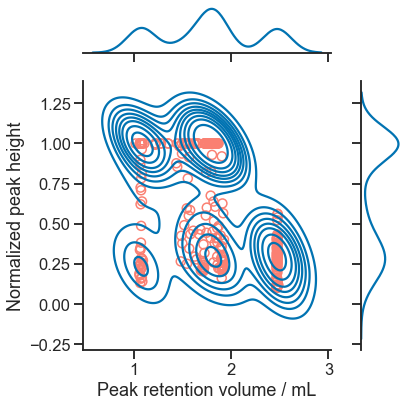

In [14]:
xs = np.hstack(df.peaks.to_list())
ys = np.hstack(df.peak_heights.to_list())
g = sns.jointplot(
    x=xs, 
    y=ys, 
    kind='kde', 
    ratio=4,
)
g.ax_joint.scatter(xs, ys, facecolors='none', edgecolor='salmon')
g.ax_joint.set_xlabel('Peak retention volume / mL')
g.ax_joint.set_ylabel('Normalized peak height')
plt.tight_layout()
plt.savefig('peaks_distribution.png', dpi=300)
plt.show()

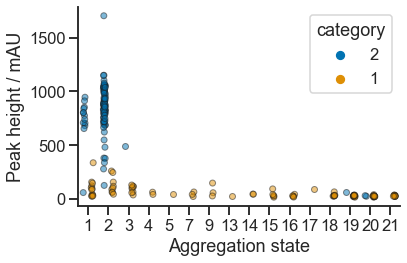

In [15]:
sns.stripplot(
    data=df.sort_values(by='main_peak_agg_state'),
    x='main_peak_agg_state', 
    y='main_peak_height',
    hue='category', 
    alpha=0.5, 
    edgecolor='k', 
    linewidth=1, 
    size=6,
    dodge=True,
)

plt.xlabel('Aggregation state')
plt.ylabel('Peak height / mAU')
plt.tight_layout()
plt.savefig('aggregation_states.png', dpi=300)
plt.show()

## Per-well results

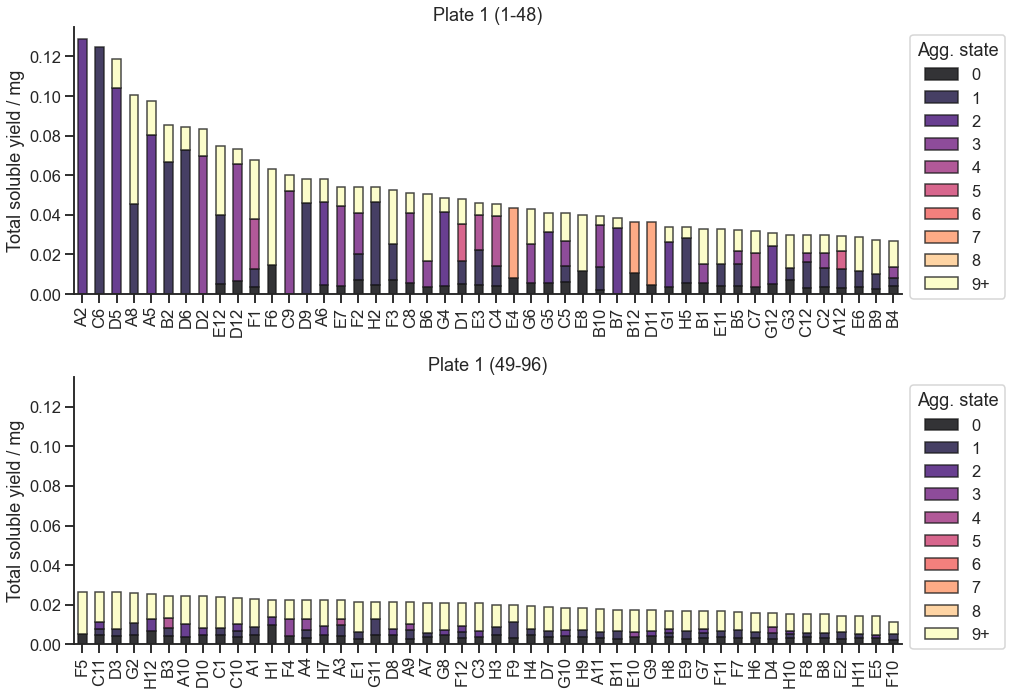

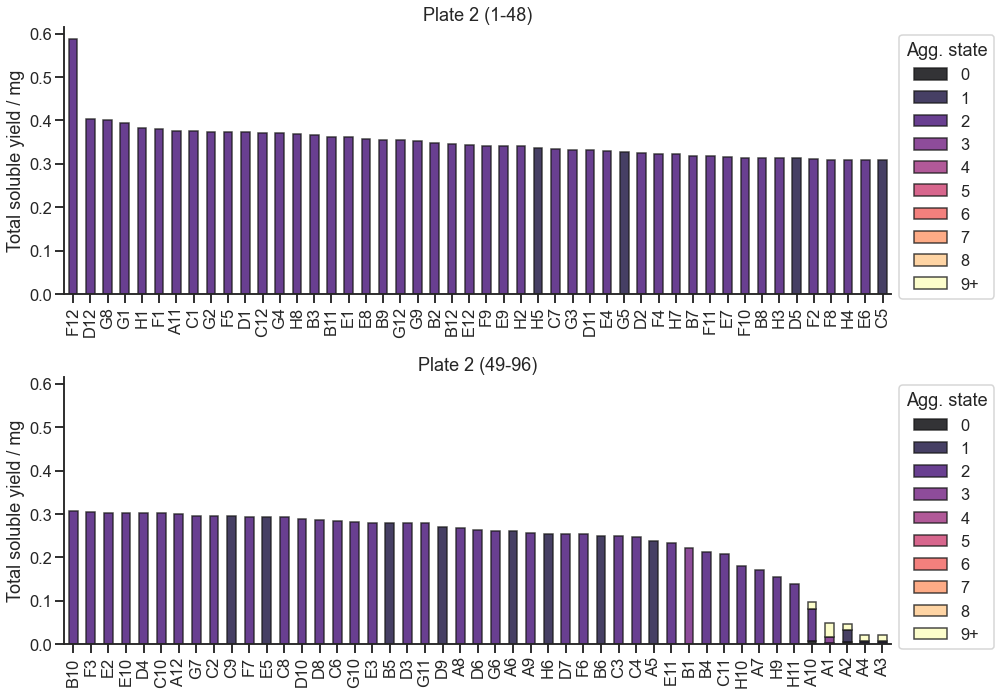

In [16]:
for plate, sel in df.groupby('Destination Plate Name'):
    
    states = [str(i) for i in range(9)] + ['9+']
    
    agg_df = pd.DataFrame(
        index=sel['Destination Well'].to_list(),
        columns=states,
    )
    
    agg_df = agg_df.merge(
        sel[['tot_yield', 'Destination Well']], 
        left_index=True, 
        right_on='Destination Well'
    ).set_index('Destination Well', drop=True)
    
    agg_df.fillna(0, inplace=True)
    
    for i, r in sel.iterrows():
        agg_states = [round(Vel2MW(v) / r.protomer_MW) for v in r.peaks]
        proportions = r.tot_yield * r.peak_heights / r.peak_heights.sum()

        for agg_st, prop in zip(agg_states, proportions):

            if agg_st < 9:
                agg_df.loc[r['Destination Well'], str(agg_st)] += prop

            else:
                agg_df.loc[r['Destination Well'], '9+'] += prop

    agg_df.sort_values(
        by=['tot_yield'] + states,
        ascending=False,
        inplace=True,
    )
   
    n_subplots = np.ceil(len(agg_df)/48).astype(int)
    fig, ax = plt.subplots(
        nrows=n_subplots, 
        figsize=(len(agg_df)/n_subplots*.3, 5*n_subplots),
        sharey=True,
    )

    if n_subplots == 1:
        ax = [ax]

    for i in range(n_subplots):
        agg_df.iloc[48*i:48*(i+1)][states].plot(
            ax=ax[i],
            kind='bar', 
            stacked=True, 
            edgecolor='k',
            alpha=0.80,
            cmap='magma',
        )

        ax[i].legend(bbox_to_anchor=(1,1), title='Agg. state')
        ax[i].set(xlabel='', ylabel='Total soluble yield / mg')
        ax[i].set_title(f'Plate {plate} ({48*i+1}-{48*(i+1)})')
    plt.tight_layout()
    plt.savefig(f'plate_{plate}_agg_per_well.png', dpi=300)
    plt.show()


## Pool fractions

- Choose the number of fraction to pool with `n_fractions`. Only adjacent fractions will be picked.
    - The tolerance (in mL) for what qualifies as adjacent can be specified with `adjacency`.

<!-- -->
- Choose the fraction picking logic with `how`:
    - `largest` will pick the fraction with the largest integral.
    - `nearest` will pick the fraction containing the *peak* nearest to the expected elution volume.

<!-- -->
- Use `manual_edits` if you want to overwrite the fractions that are automatically picked.


In [23]:
manual_edits = np.array([
    ['well_id', ['fraction1', 'fraction2', ]],
    ['1_B5', ['1-P1-D5', '1-P1-D3']],
], dtype=object)

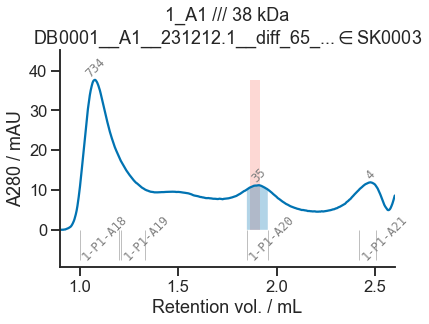

Next best fraction:
['1_A1', ['1-P1-A18']],


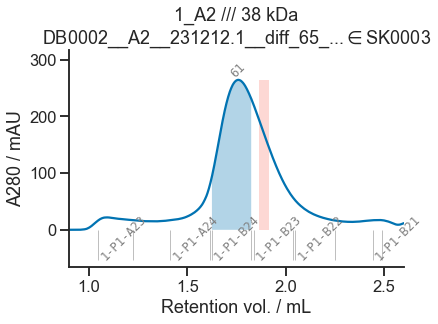

Next best fraction:
['1_A2', ['1-P1-B23']],


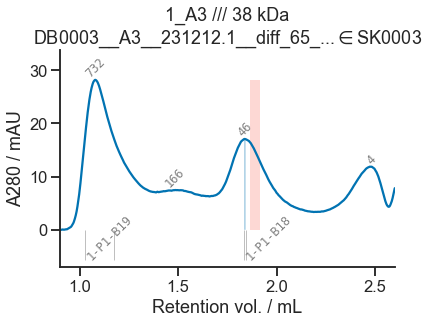

Next best fraction:
['1_A3', ['1-P1-B19']],


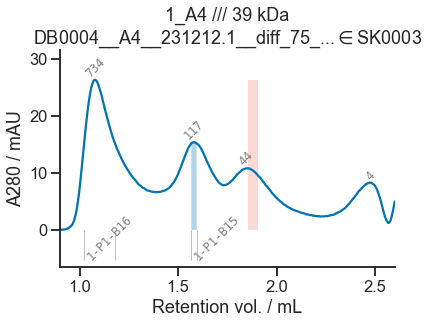

Next best fraction:
['1_A4', ['1-P1-B16']],


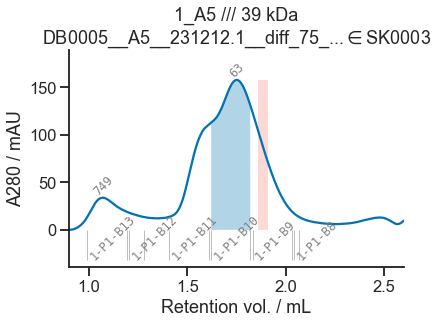

Next best fraction:
['1_A5', ['1-P1-B9']],


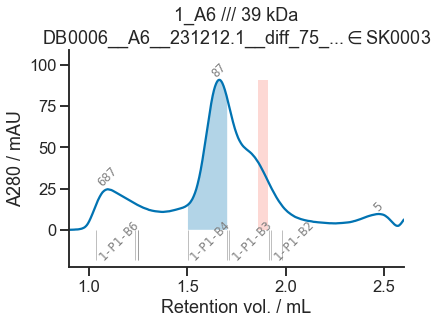

Next best fraction:
['1_A6', ['1-P1-B3']],


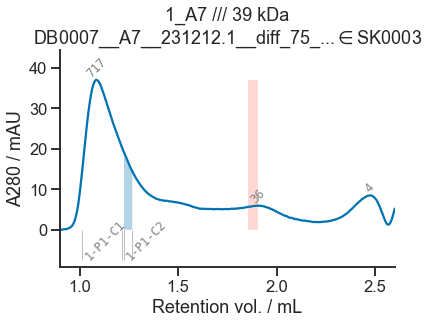

Next best fraction:
['1_A7', ['1-P1-C1']],


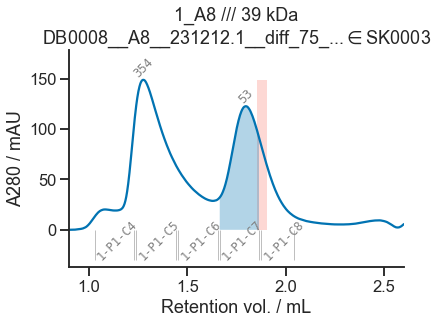

Next best fraction:
['1_A8', ['1-P1-C5']],


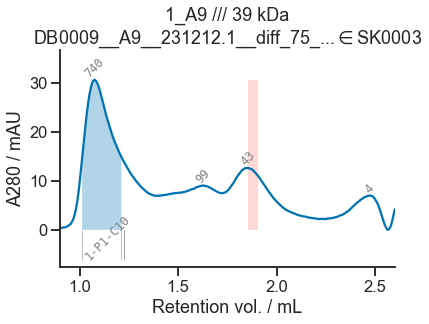

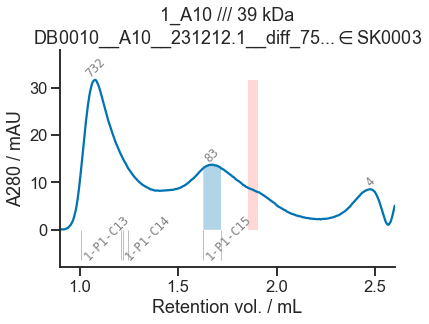

Next best fraction:
['1_A10', ['1-P1-C13']],


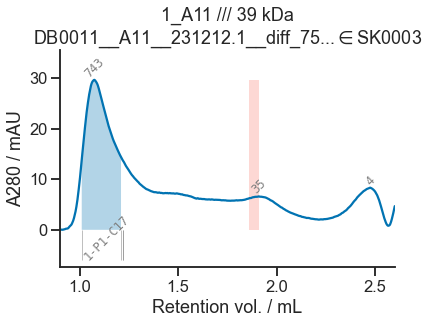

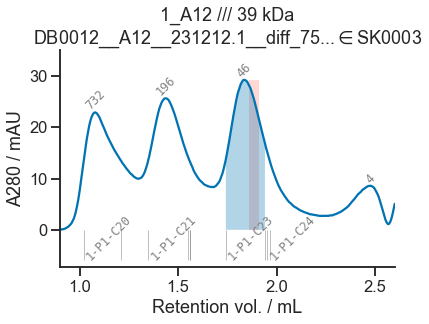

Next best fraction:
['1_A12', ['1-P1-C21']],


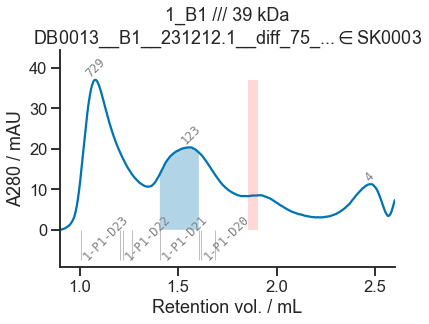

Next best fraction:
['1_B1', ['1-P1-D23']],


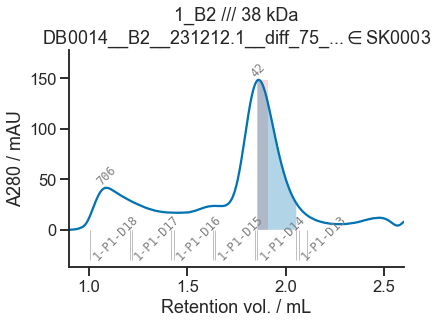

Next best fraction:
['1_B2', ['1-P1-D15']],


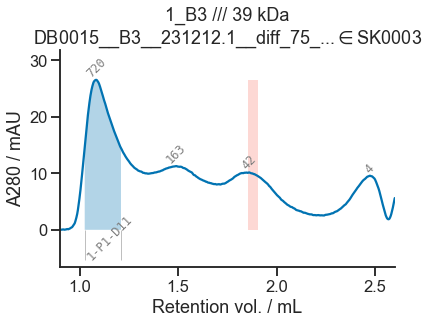

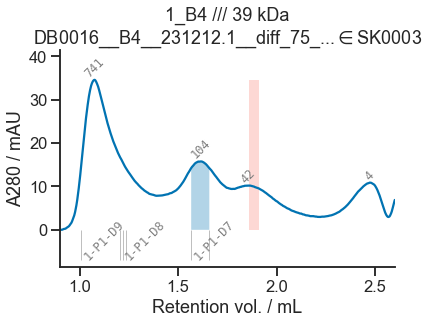

Next best fraction:
['1_B4', ['1-P1-D9']],


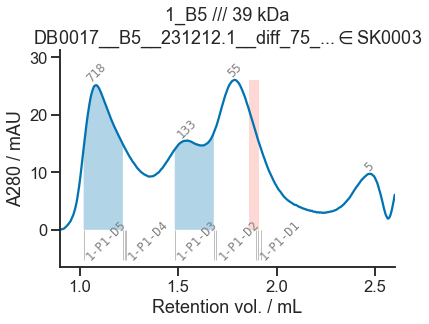

Next best fraction:
['1_B5', ['1-P1-D2']],


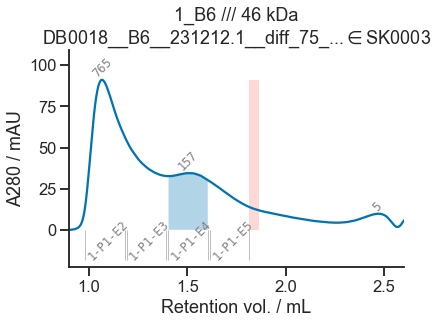

Next best fraction:
['1_B6', ['1-P1-E2']],


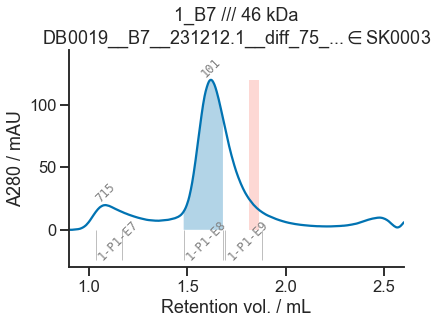

Next best fraction:
['1_B7', ['1-P1-E9']],


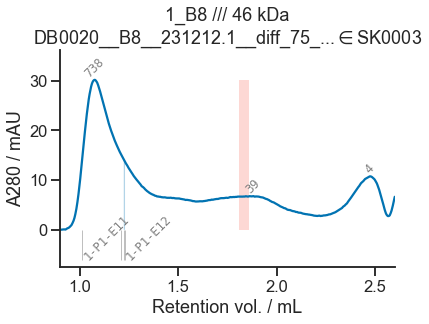

Next best fraction:
['1_B8', ['1-P1-E11']],


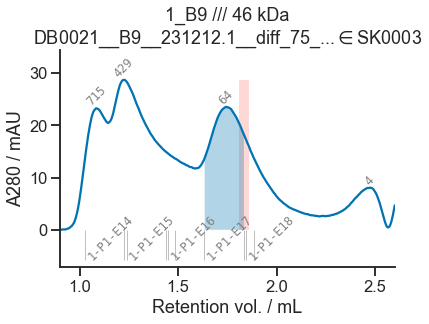

Next best fraction:
['1_B9', ['1-P1-E14']],


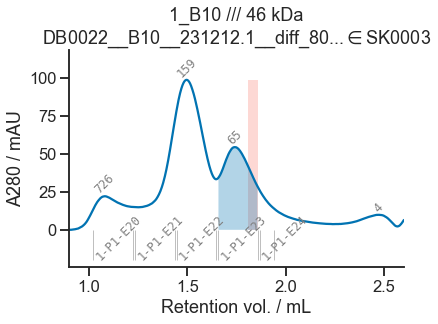

Next best fraction:
['1_B10', ['1-P1-E22']],


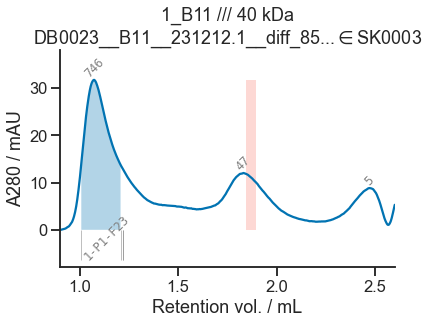

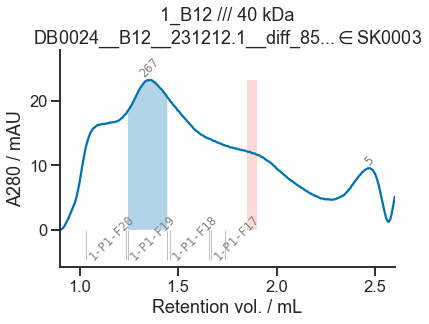

Next best fraction:
['1_B12', ['1-P1-F18']],


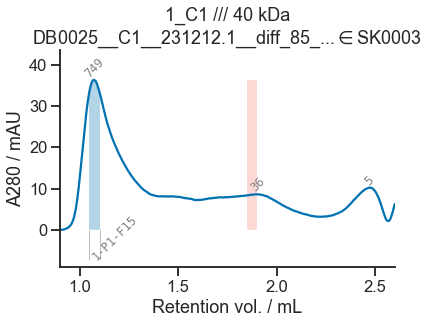

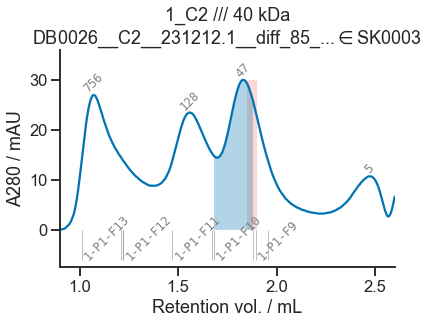

Next best fraction:
['1_C2', ['1-P1-F13']],


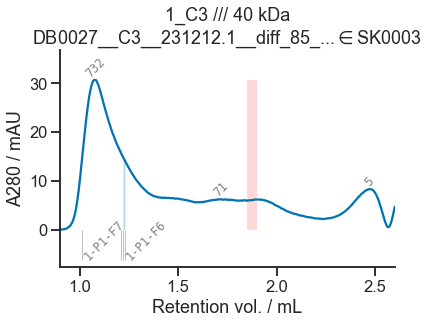

Next best fraction:
['1_C3', ['1-P1-F7']],


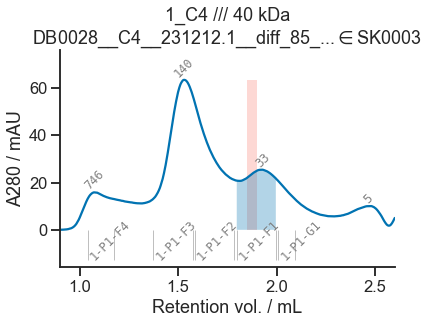

Next best fraction:
['1_C4', ['1-P1-F3']],


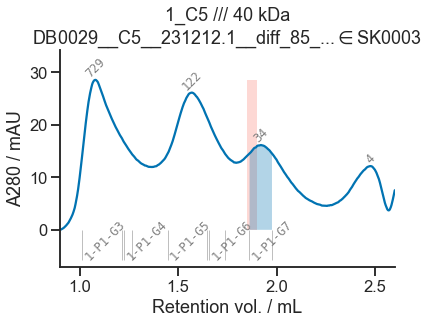

Next best fraction:
['1_C5', ['1-P1-G3']],


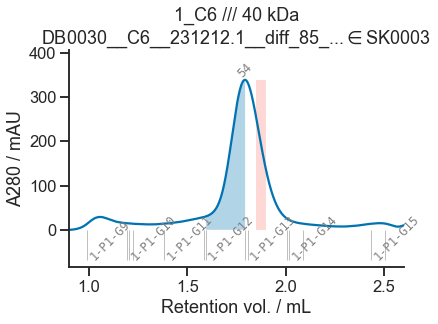

Next best fraction:
['1_C6', ['1-P1-G13']],


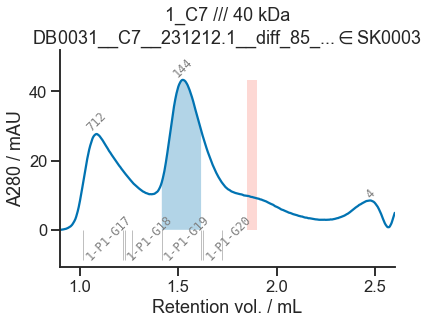

Next best fraction:
['1_C7', ['1-P1-G17']],


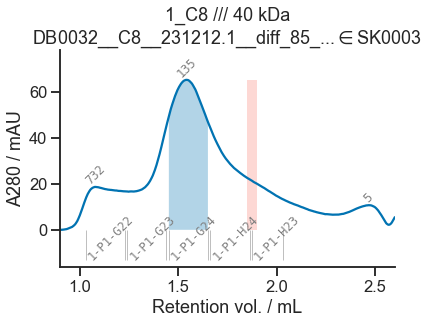

Next best fraction:
['1_C8', ['1-P1-H24']],


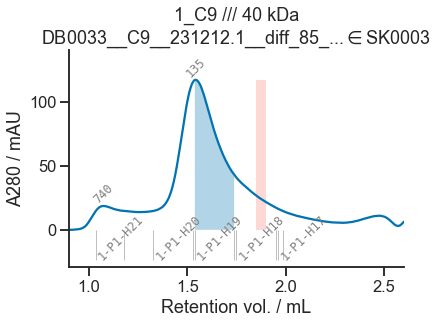

Next best fraction:
['1_C9', ['1-P1-H20']],


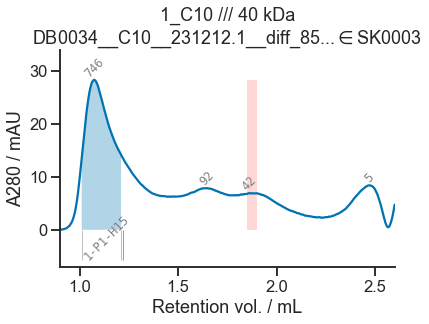

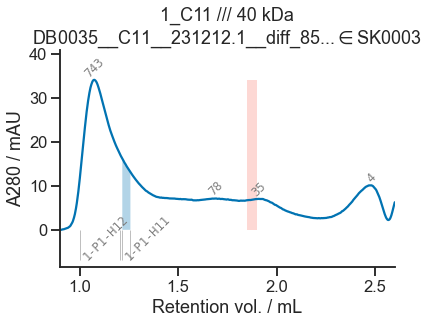

Next best fraction:
['1_C11', ['1-P1-H12']],


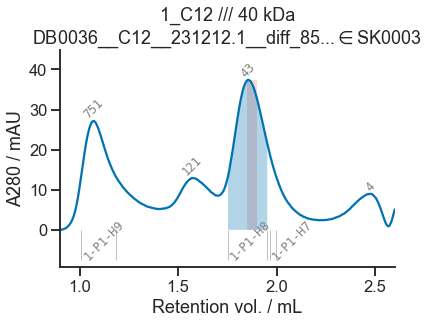

Next best fraction:
['1_C12', ['1-P1-H9']],


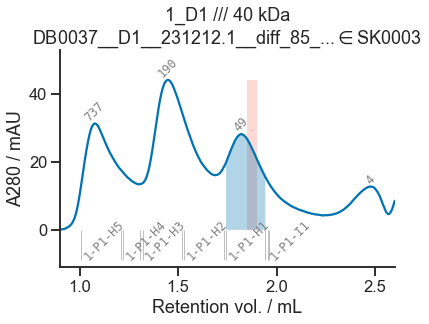

Next best fraction:
['1_D1', ['1-P1-H3']],


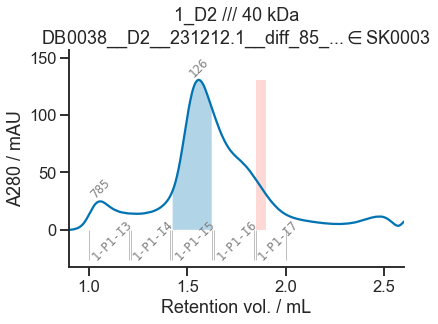

Next best fraction:
['1_D2', ['1-P1-I6']],


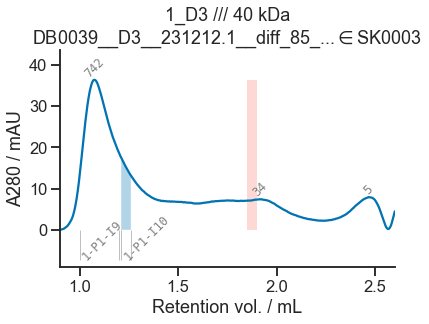

Next best fraction:
['1_D3', ['1-P1-I9']],


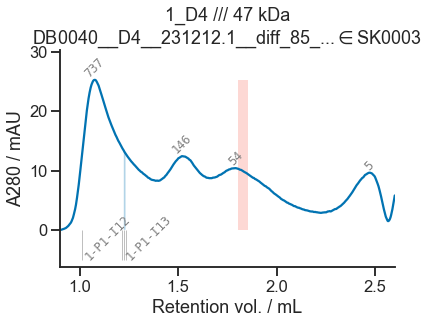

Next best fraction:
['1_D4', ['1-P1-I12']],


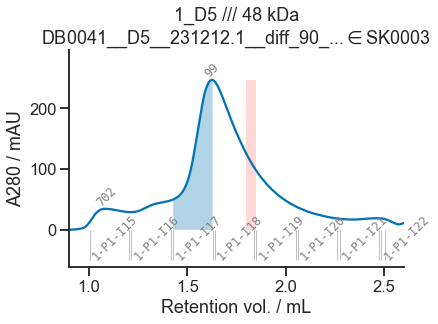

Next best fraction:
['1_D5', ['1-P1-I18']],


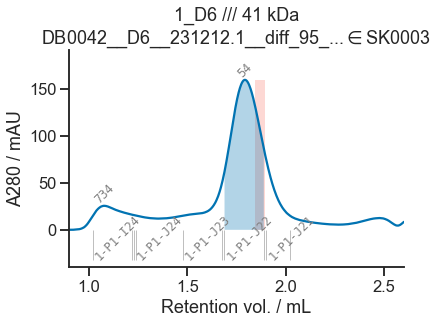

Next best fraction:
['1_D6', ['1-P1-J21']],


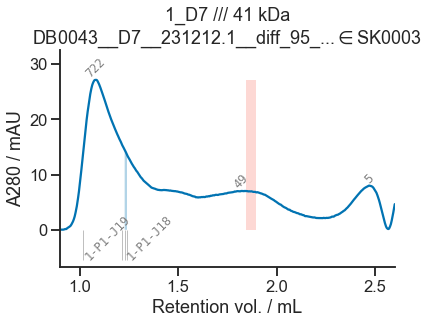

Next best fraction:
['1_D7', ['1-P1-J19']],


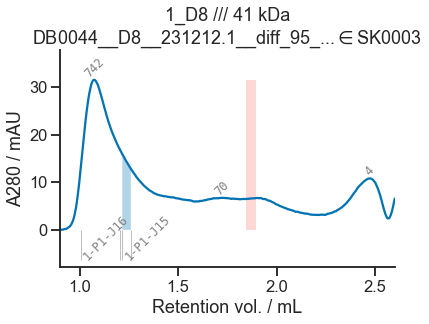

Next best fraction:
['1_D8', ['1-P1-J16']],


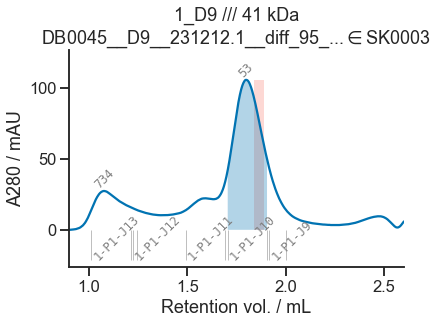

Next best fraction:
['1_D9', ['1-P1-J13']],


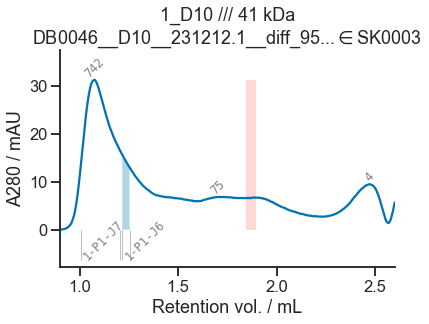

Next best fraction:
['1_D10', ['1-P1-J7']],


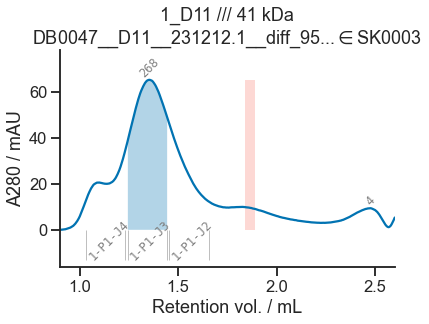

Next best fraction:
['1_D11', ['1-P1-J2']],


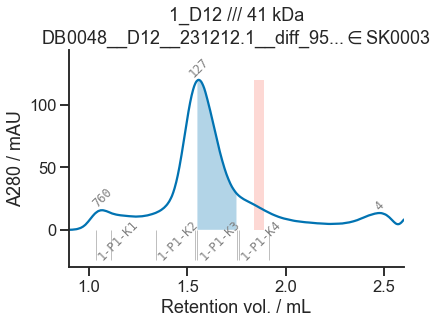

Next best fraction:
['1_D12', ['1-P1-K2']],


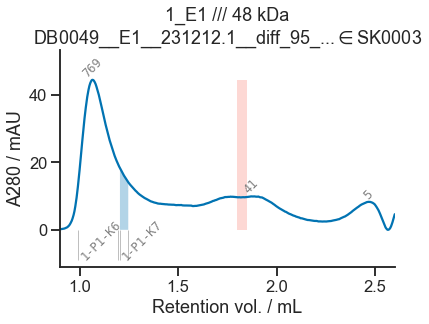

Next best fraction:
['1_E1', ['1-P1-K6']],


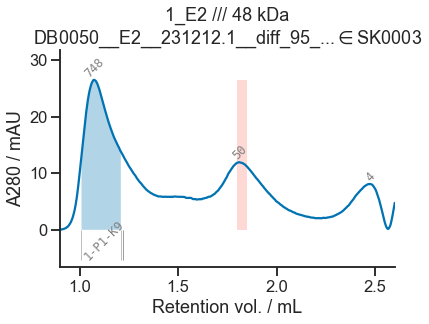

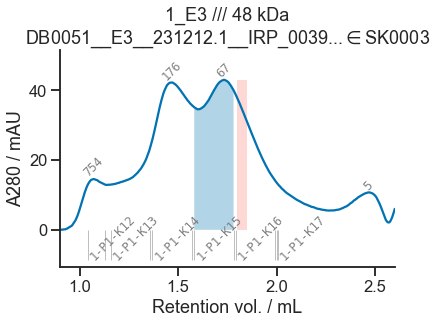

Next best fraction:
['1_E3', ['1-P1-K14']],


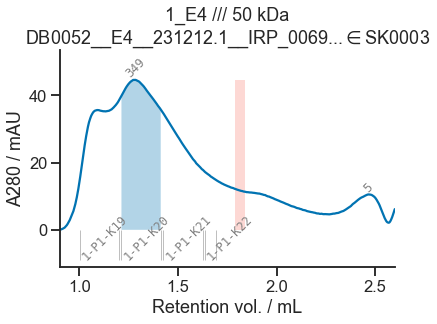

Next best fraction:
['1_E4', ['1-P1-K19']],


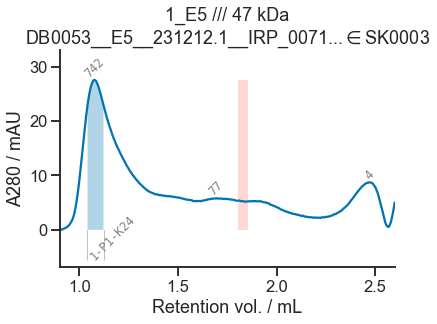

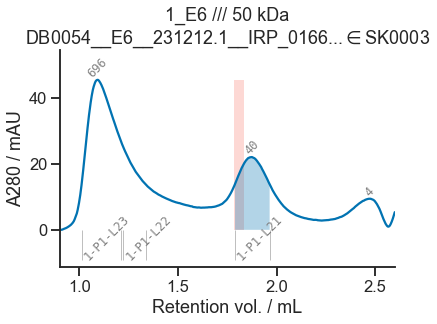

Next best fraction:
['1_E6', ['1-P1-L23']],


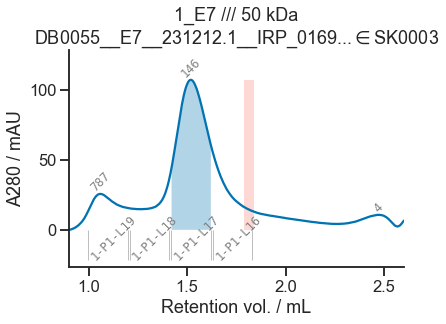

Next best fraction:
['1_E7', ['1-P1-L16']],


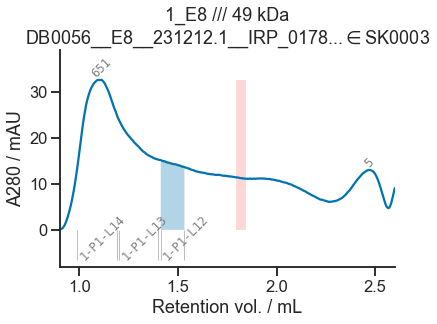

Next best fraction:
['1_E8', ['1-P1-L14']],


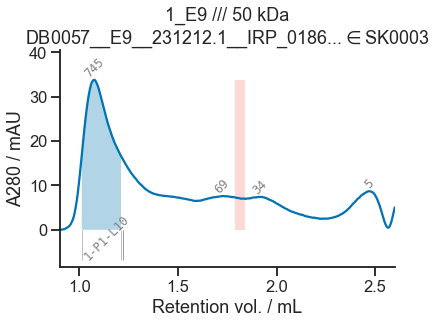

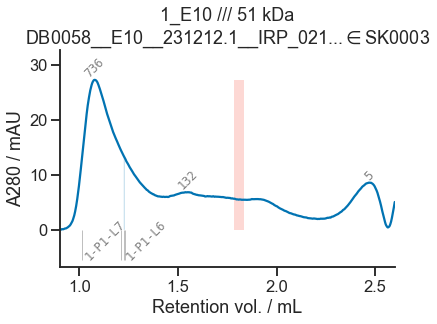

Next best fraction:
['1_E10', ['1-P1-L7']],


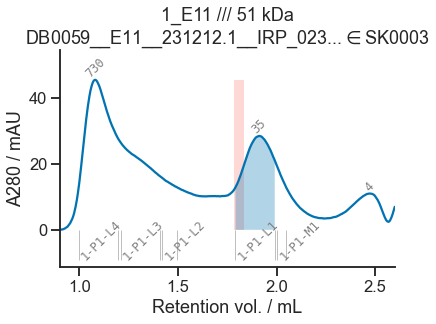

Next best fraction:
['1_E11', ['1-P1-L4']],


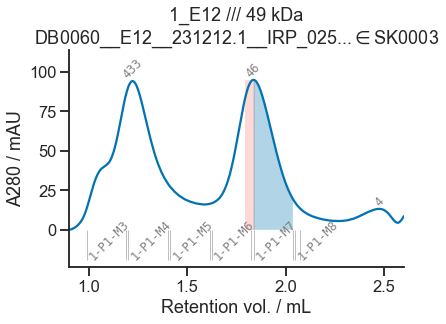

Next best fraction:
['1_E12', ['1-P1-M4']],


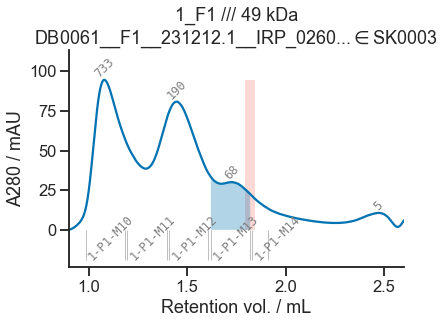

Next best fraction:
['1_F1', ['1-P1-M10']],


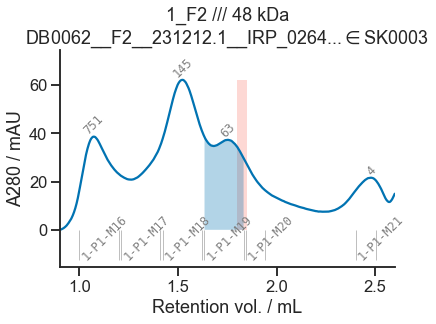

Next best fraction:
['1_F2', ['1-P1-M18']],


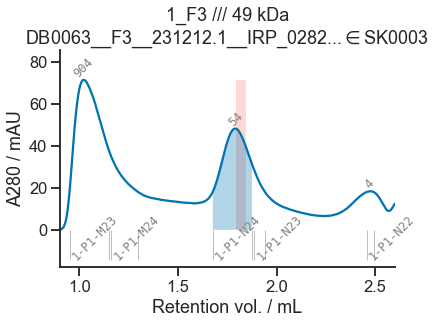

Next best fraction:
['1_F3', ['1-P1-M23']],


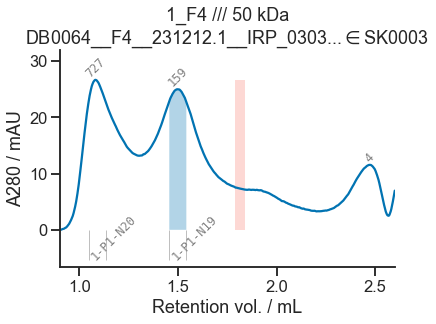

Next best fraction:
['1_F4', ['1-P1-N20']],


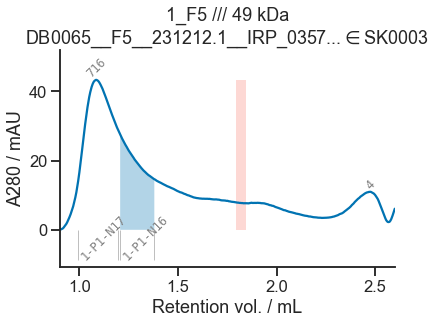

Next best fraction:
['1_F5', ['1-P1-N17']],


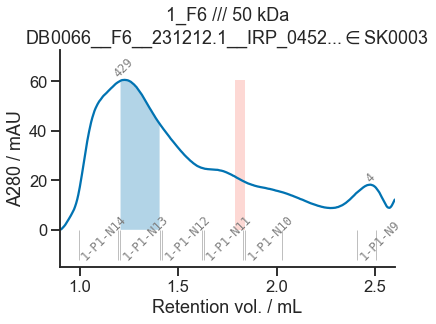

Next best fraction:
['1_F6', ['1-P1-N14']],


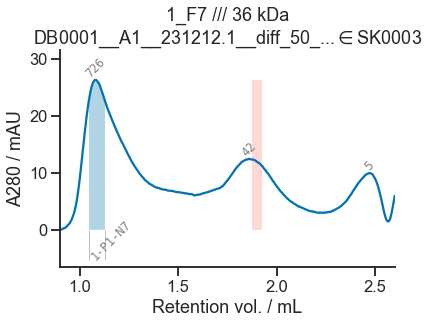

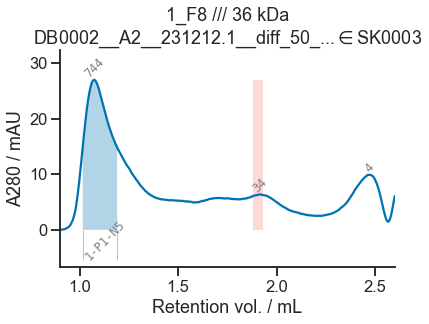

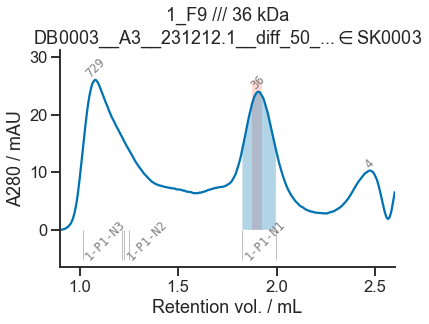

Next best fraction:
['1_F9', ['1-P1-N3']],


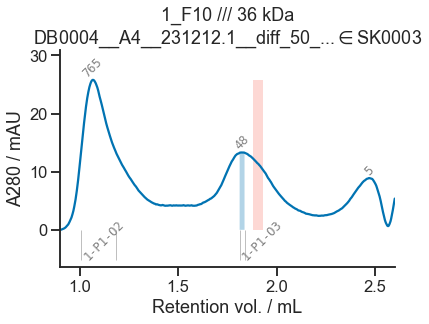

Next best fraction:
['1_F10', ['1-P1-O2']],


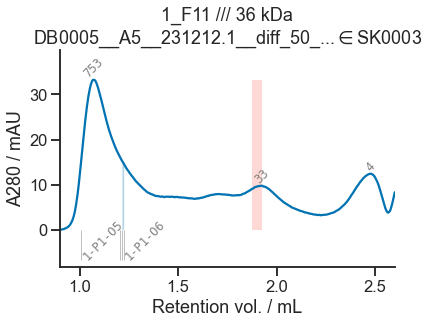

Next best fraction:
['1_F11', ['1-P1-O5']],


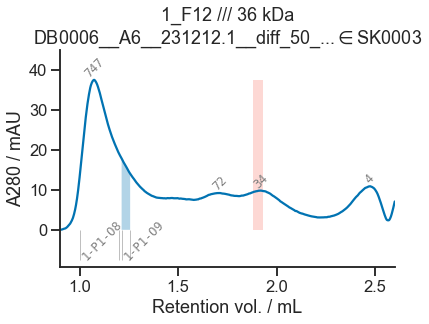

Next best fraction:
['1_F12', ['1-P1-O8']],


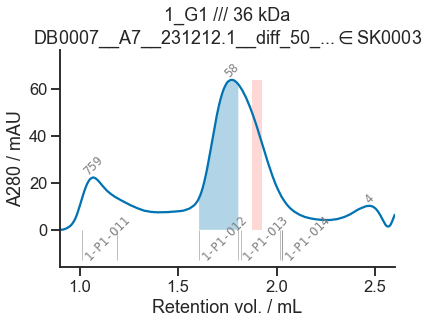

Next best fraction:
['1_G1', ['1-P1-O13']],


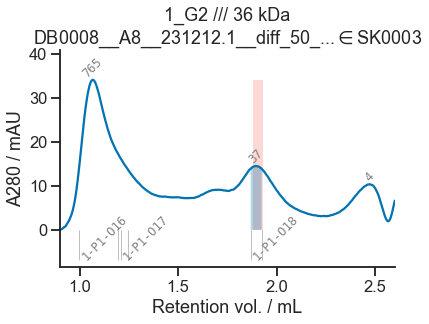

Next best fraction:
['1_G2', ['1-P1-O16']],


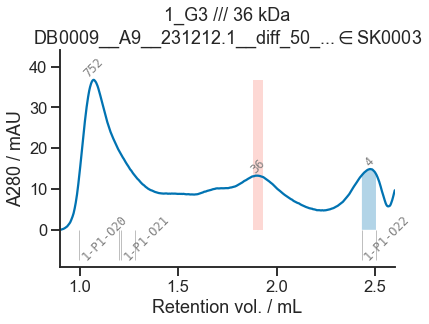

Next best fraction:
['1_G3', ['1-P1-O20']],


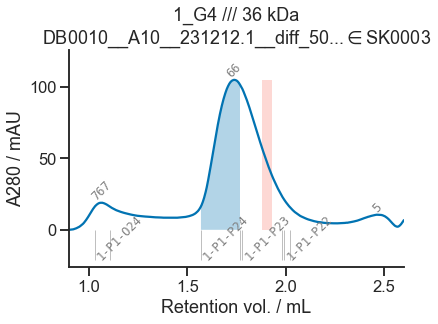

Next best fraction:
['1_G4', ['1-P1-P23']],


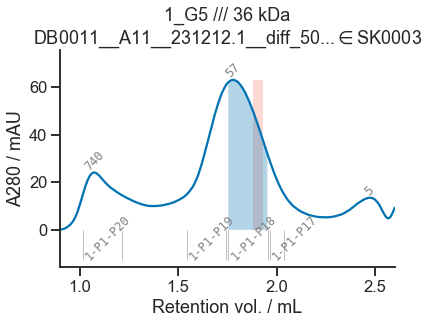

Next best fraction:
['1_G5', ['1-P1-P19']],


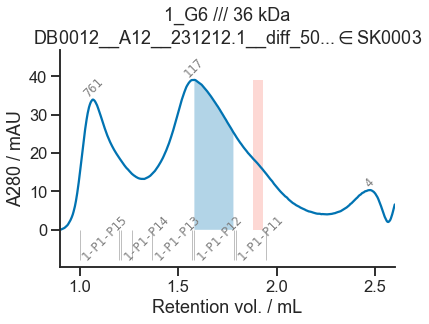

Next best fraction:
['1_G6', ['1-P1-P15']],


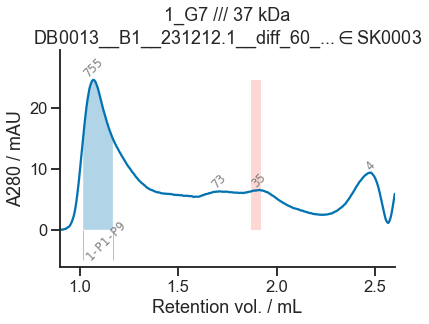

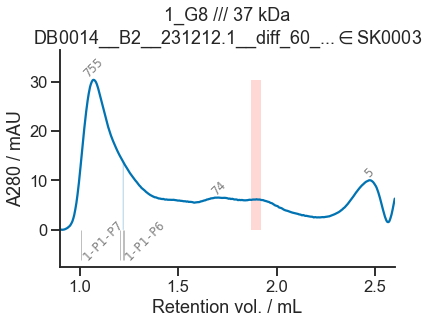

Next best fraction:
['1_G8', ['1-P1-P7']],


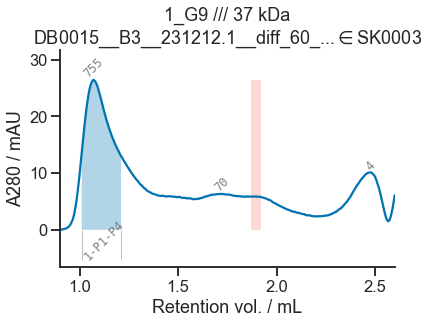

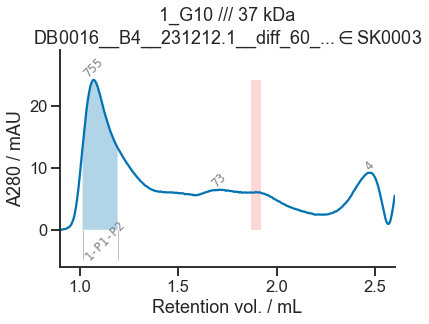

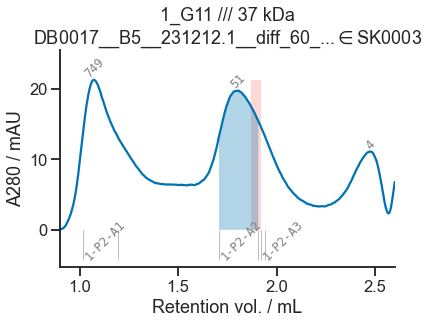

Next best fraction:
['1_G11', ['1-P2-A1']],


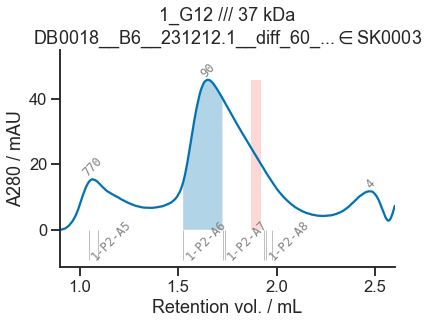

Next best fraction:
['1_G12', ['1-P2-A7']],


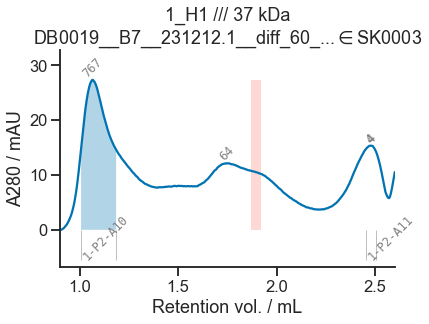

Next best fraction:
['1_H1', ['1-P2-A11']],


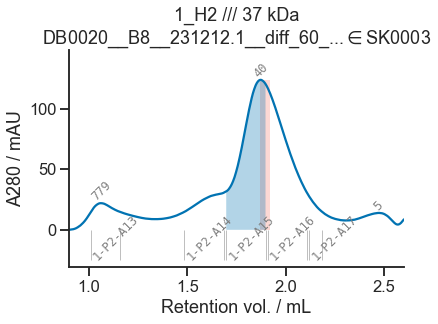

Next best fraction:
['1_H2', ['1-P2-A16']],


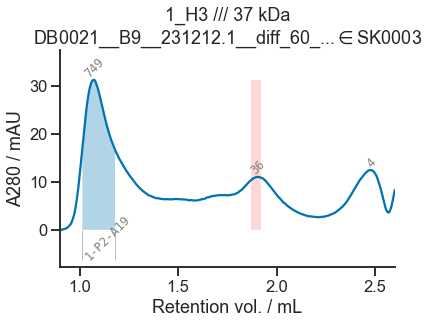

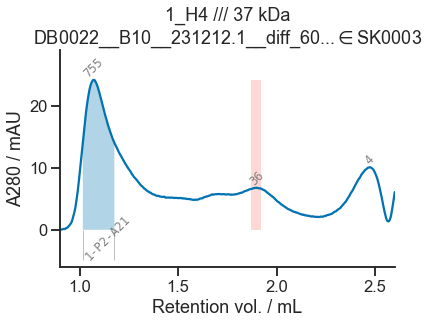

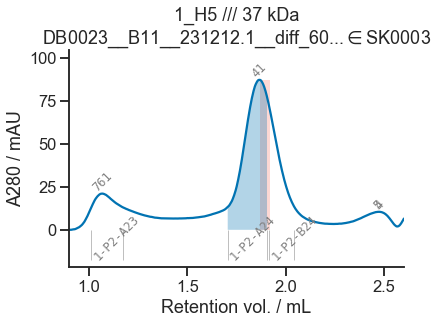

Next best fraction:
['1_H5', ['1-P2-B24']],


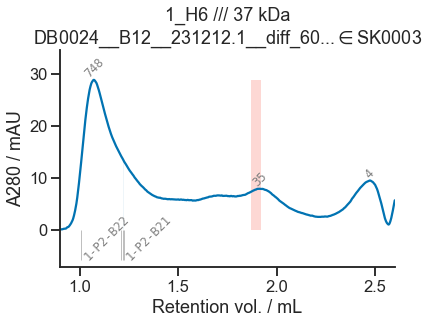

Next best fraction:
['1_H6', ['1-P2-B22']],


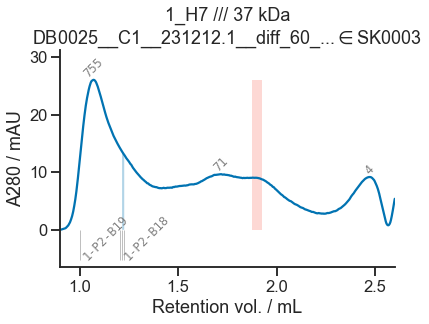

Next best fraction:
['1_H7', ['1-P2-B19']],


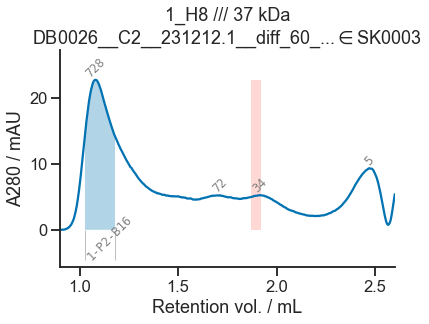

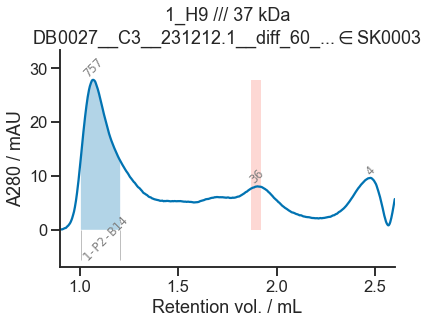

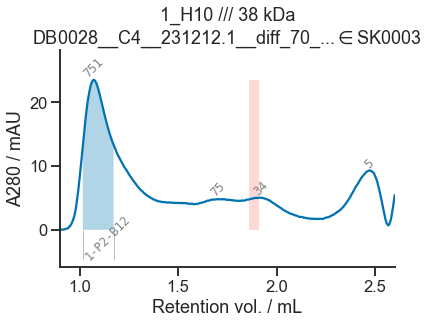

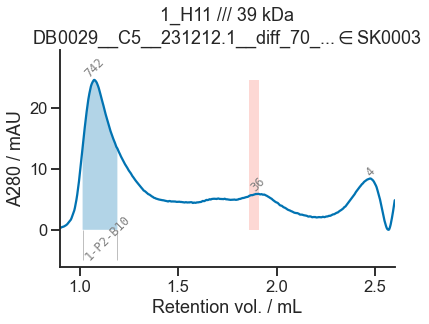

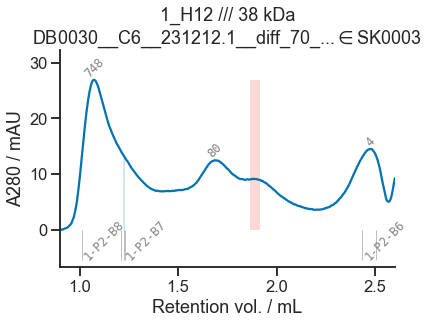

Next best fraction:
['1_H12', ['1-P2-B8']],


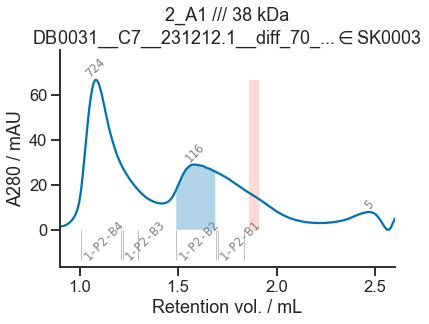

Next best fraction:
['2_A1', ['1-P2-B4']],


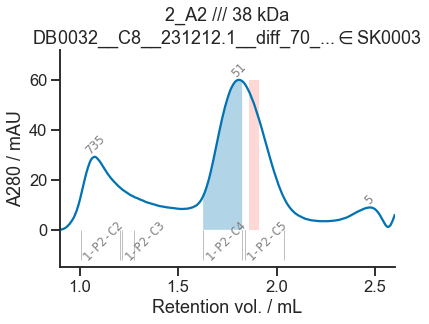

Next best fraction:
['2_A2', ['1-P2-C5']],


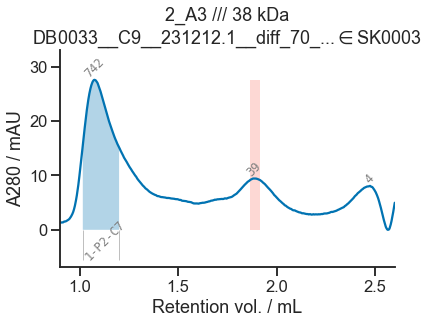

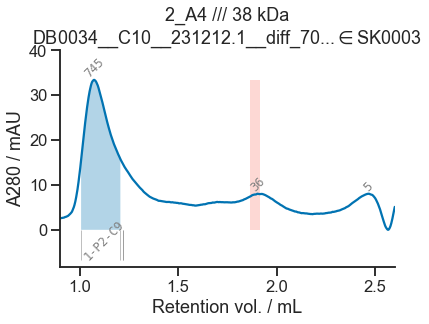

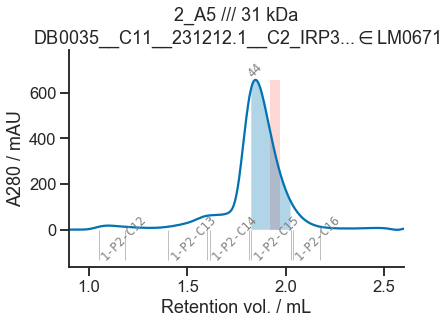

Next best fraction:
['2_A5', ['1-P2-C14']],


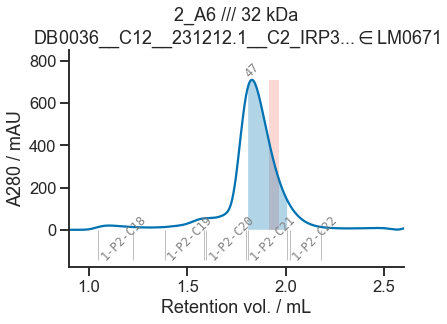

Next best fraction:
['2_A6', ['1-P2-C20']],


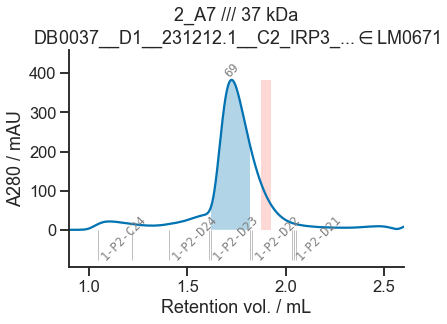

Next best fraction:
['2_A7', ['1-P2-D22']],


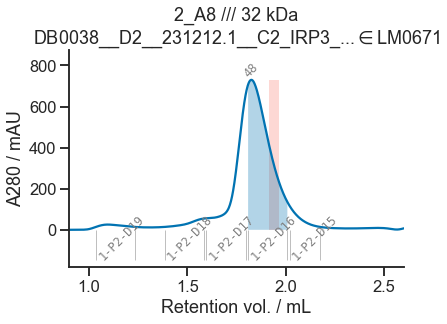

Next best fraction:
['2_A8', ['1-P2-D17']],


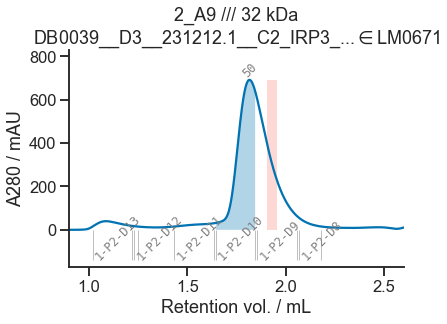

Next best fraction:
['2_A9', ['1-P2-D9']],


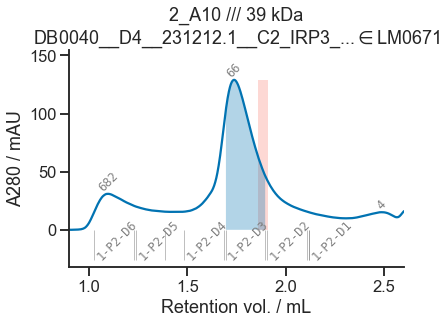

Next best fraction:
['2_A10', ['1-P2-D4']],


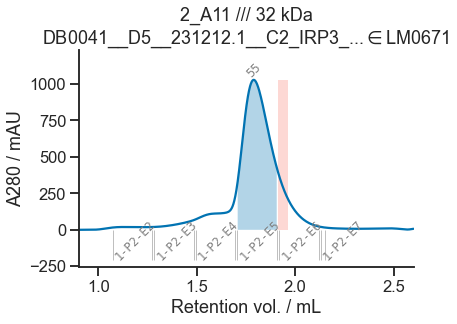

Next best fraction:
['2_A11', ['1-P2-E6']],


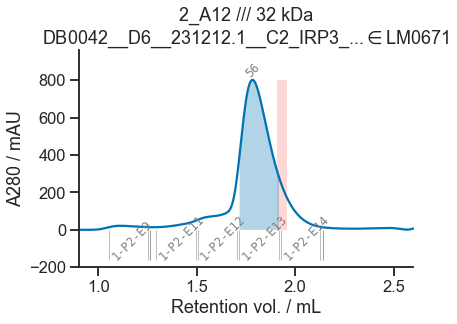

Next best fraction:
['2_A12', ['1-P2-E12']],


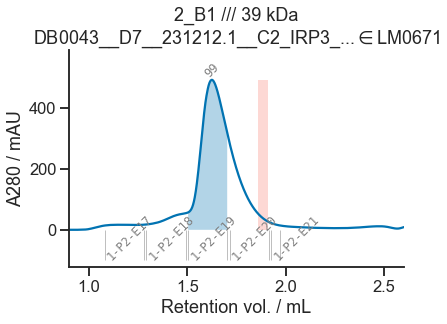

Next best fraction:
['2_B1', ['1-P2-E20']],


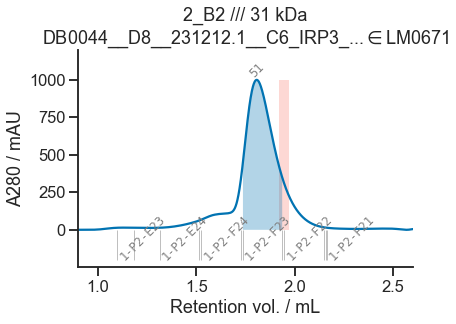

Next best fraction:
['2_B2', ['1-P2-F24']],


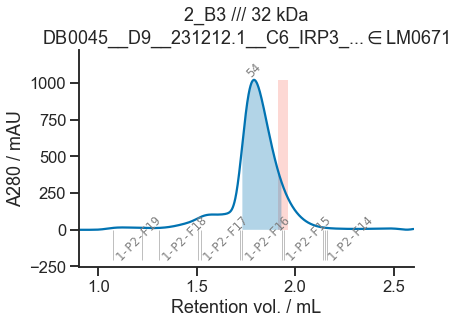

Next best fraction:
['2_B3', ['1-P2-F17']],


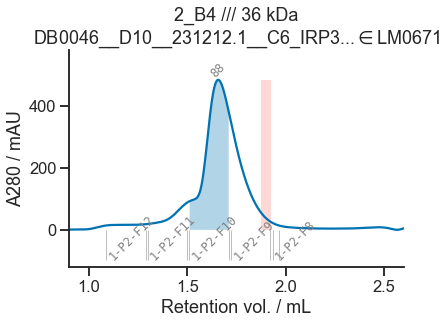

Next best fraction:
['2_B4', ['1-P2-F9']],


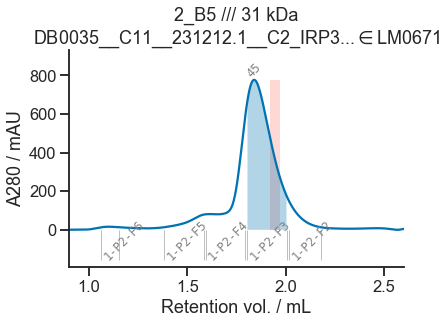

Next best fraction:
['2_B5', ['1-P2-F4']],


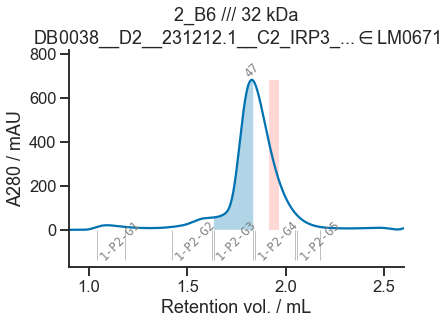

Next best fraction:
['2_B6', ['1-P2-G4']],


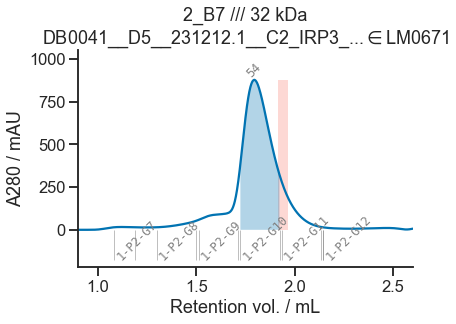

Next best fraction:
['2_B7', ['1-P2-G9']],


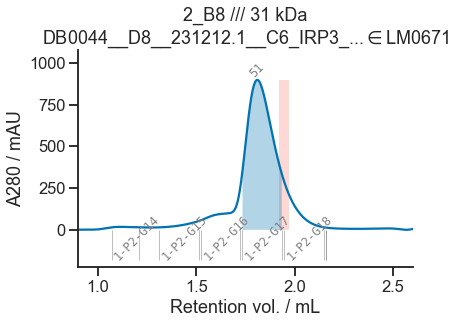

Next best fraction:
['2_B8', ['1-P2-G16']],


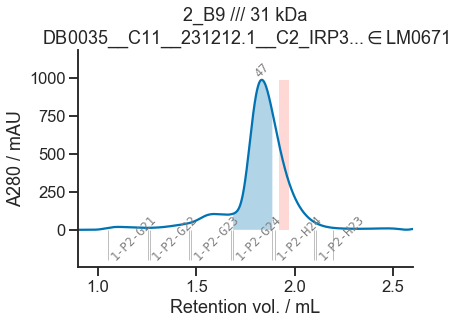

Next best fraction:
['2_B9', ['1-P2-H24']],


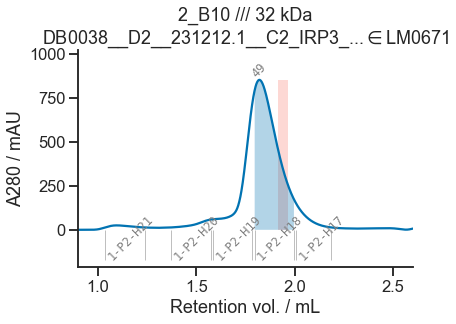

Next best fraction:
['2_B10', ['1-P2-H19']],


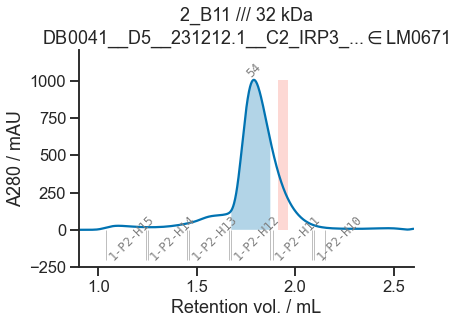

Next best fraction:
['2_B11', ['1-P2-H11']],


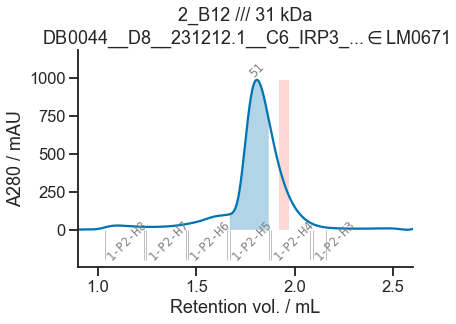

Next best fraction:
['2_B12', ['1-P2-H4']],


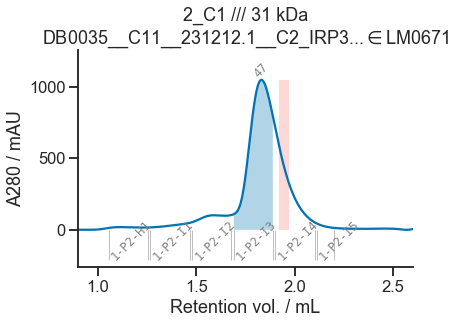

Next best fraction:
['2_C1', ['1-P2-I4']],


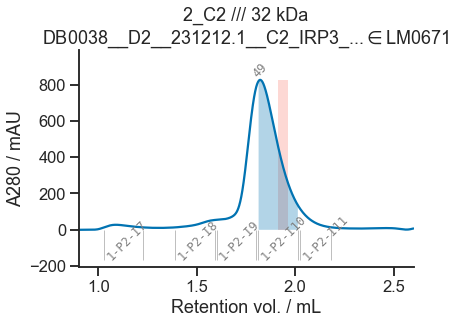

Next best fraction:
['2_C2', ['1-P2-I9']],


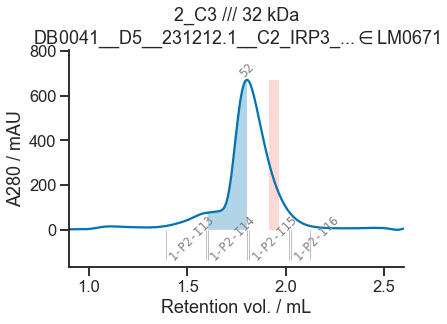

Next best fraction:
['2_C3', ['1-P2-I15']],


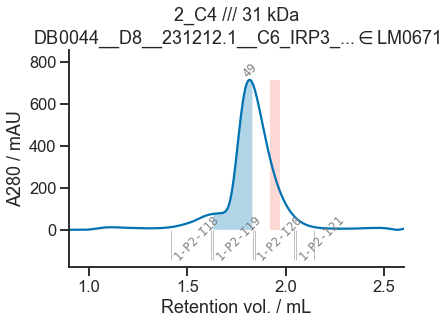

Next best fraction:
['2_C4', ['1-P2-I20']],


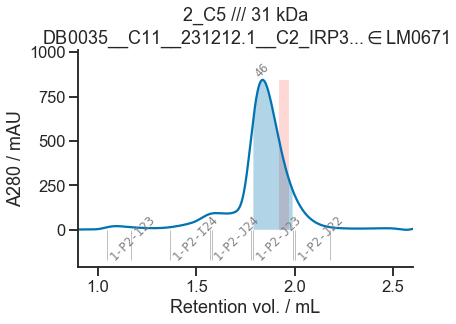

Next best fraction:
['2_C5', ['1-P2-J24']],


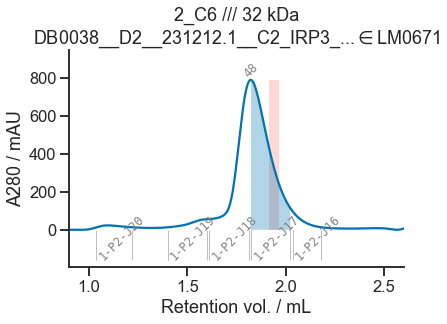

Next best fraction:
['2_C6', ['1-P2-J18']],


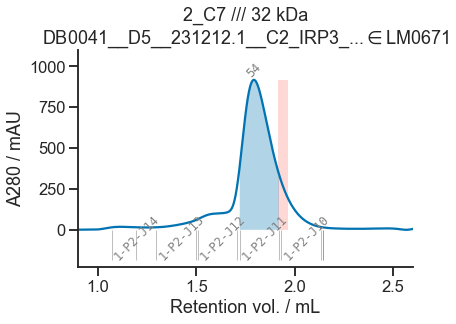

Next best fraction:
['2_C7', ['1-P2-J12']],


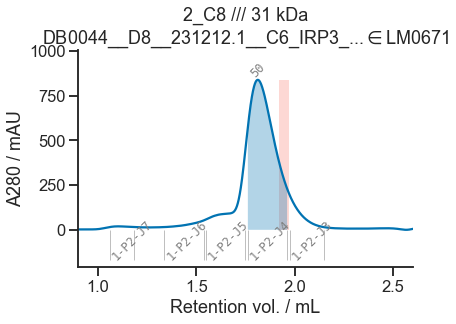

Next best fraction:
['2_C8', ['1-P2-J5']],


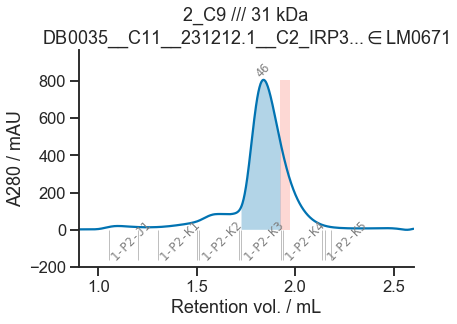

Next best fraction:
['2_C9', ['1-P2-K4']],


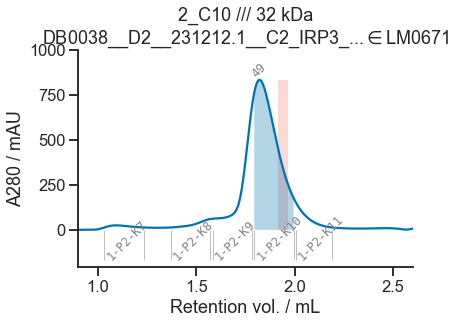

Next best fraction:
['2_C10', ['1-P2-K9']],


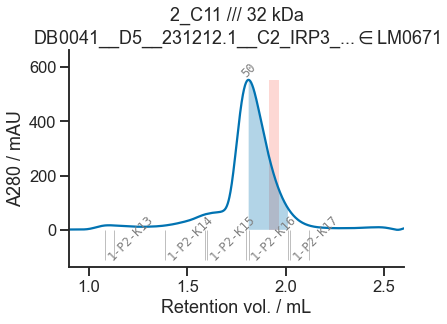

Next best fraction:
['2_C11', ['1-P2-K15']],


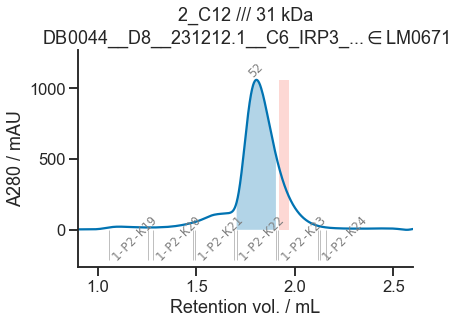

Next best fraction:
['2_C12', ['1-P2-K23']],


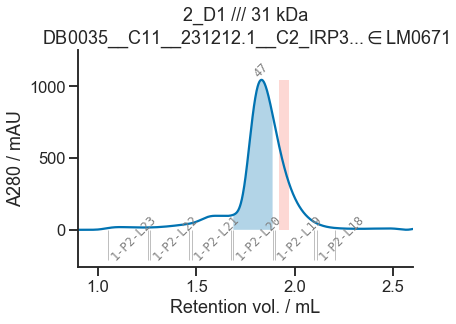

Next best fraction:
['2_D1', ['1-P2-L19']],


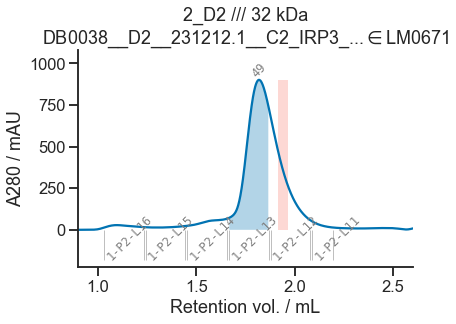

Next best fraction:
['2_D2', ['1-P2-L12']],


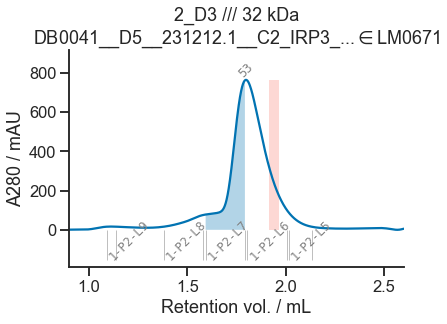

Next best fraction:
['2_D3', ['1-P2-L6']],


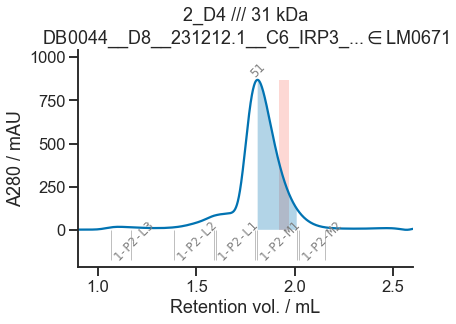

Next best fraction:
['2_D4', ['1-P2-L1']],


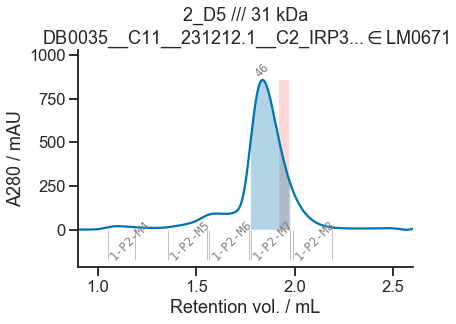

Next best fraction:
['2_D5', ['1-P2-M6']],


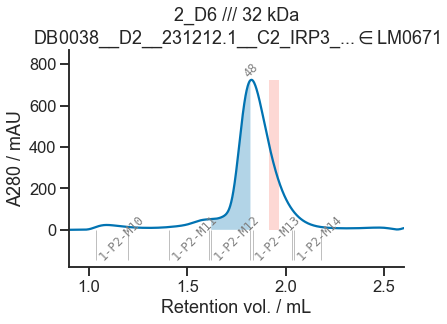

Next best fraction:
['2_D6', ['1-P2-M13']],


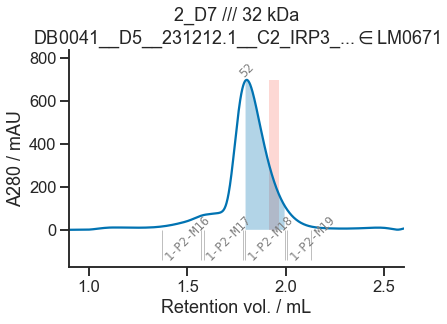

Next best fraction:
['2_D7', ['1-P2-M17']],


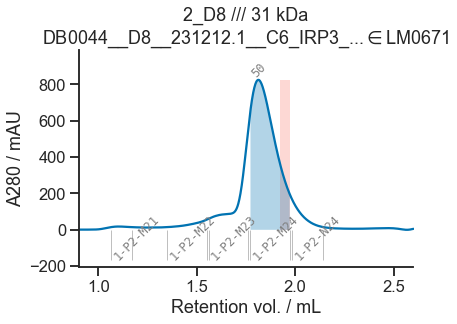

Next best fraction:
['2_D8', ['1-P2-M23']],


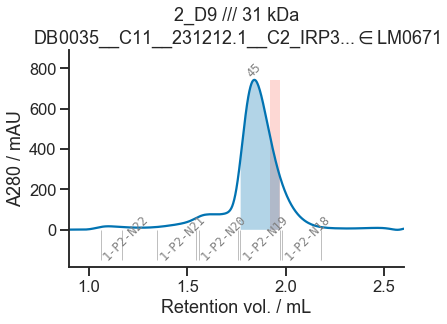

Next best fraction:
['2_D9', ['1-P2-N20']],


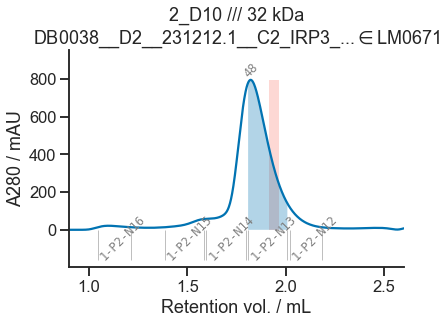

Next best fraction:
['2_D10', ['1-P2-N14']],


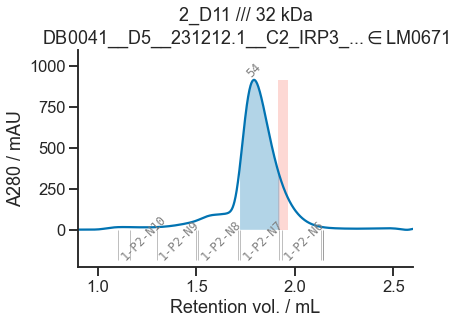

Next best fraction:
['2_D11', ['1-P2-N8']],


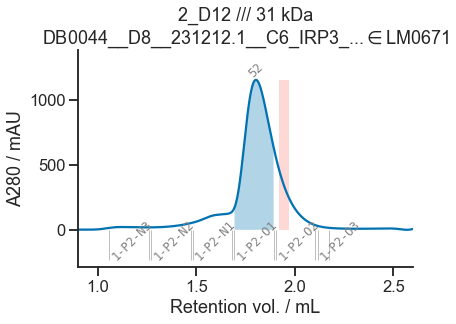

Next best fraction:
['2_D12', ['1-P2-O2']],


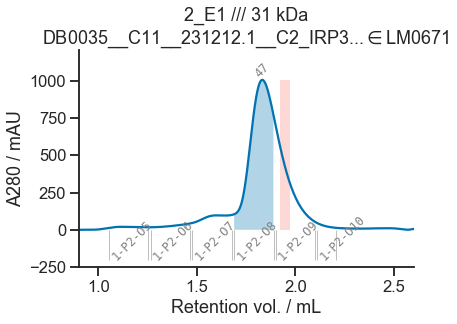

Next best fraction:
['2_E1', ['1-P2-O9']],


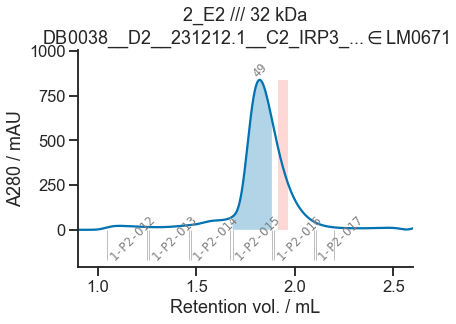

Next best fraction:
['2_E2', ['1-P2-O16']],


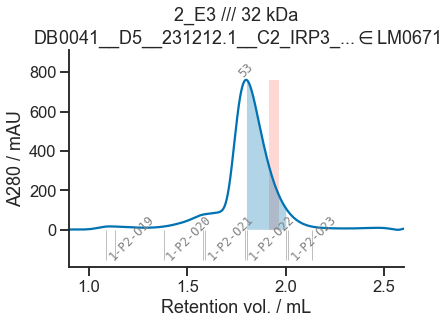

Next best fraction:
['2_E3', ['1-P2-O21']],


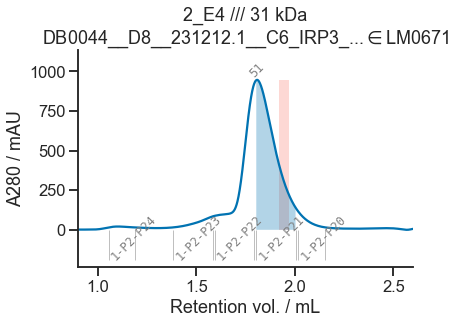

Next best fraction:
['2_E4', ['1-P2-P22']],


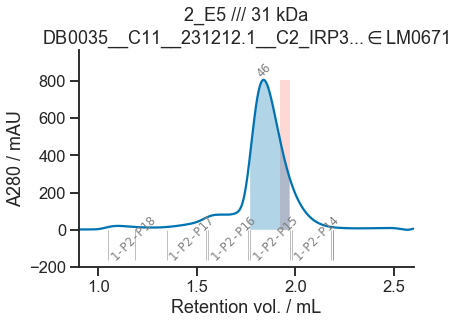

Next best fraction:
['2_E5', ['1-P2-P16']],


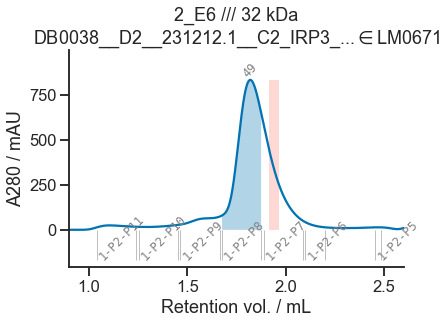

Next best fraction:
['2_E6', ['1-P2-P7']],


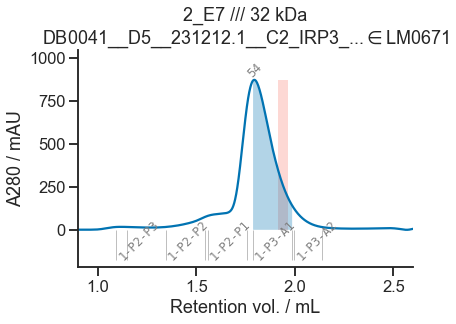

Next best fraction:
['2_E7', ['1-P2-P1']],


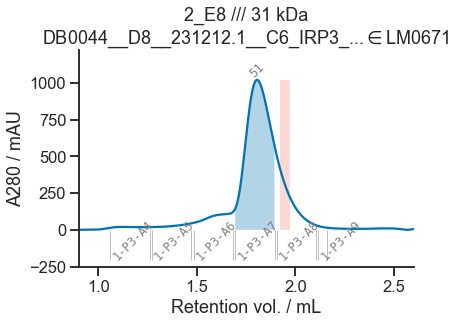

Next best fraction:
['2_E8', ['1-P3-A8']],


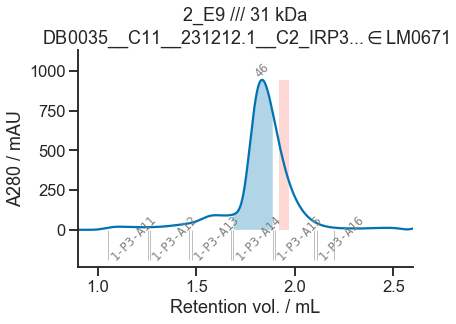

Next best fraction:
['2_E9', ['1-P3-A15']],


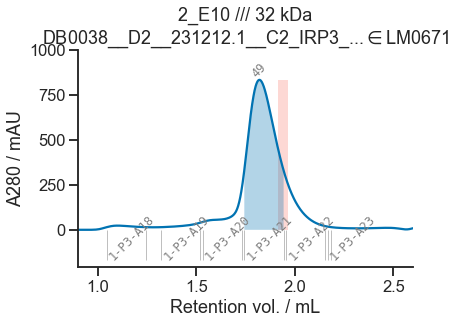

Next best fraction:
['2_E10', ['1-P3-A22']],


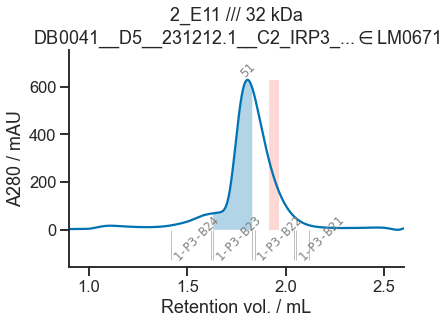

Next best fraction:
['2_E11', ['1-P3-B22']],


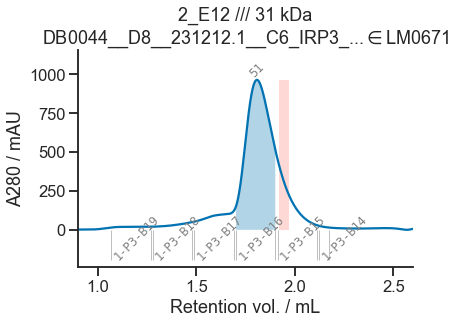

Next best fraction:
['2_E12', ['1-P3-B15']],


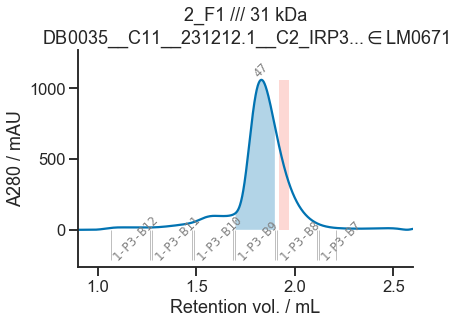

Next best fraction:
['2_F1', ['1-P3-B8']],


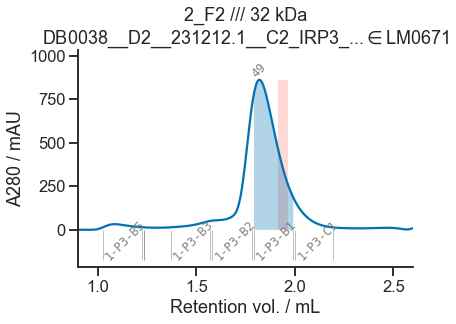

Next best fraction:
['2_F2', ['1-P3-B2']],


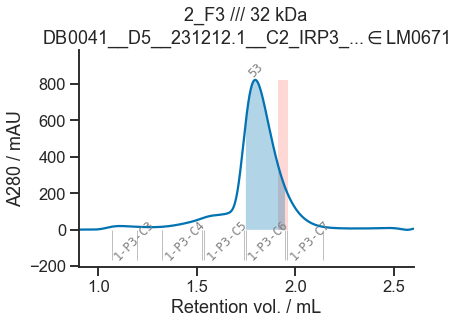

Next best fraction:
['2_F3', ['1-P3-C5']],


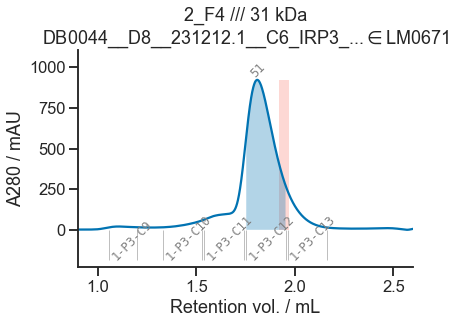

Next best fraction:
['2_F4', ['1-P3-C11']],


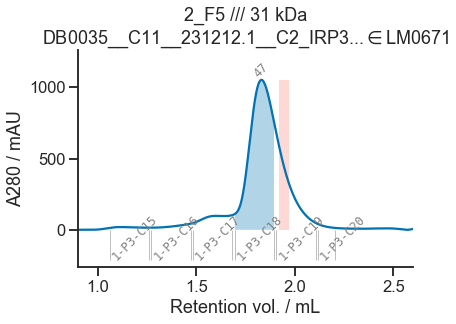

Next best fraction:
['2_F5', ['1-P3-C19']],


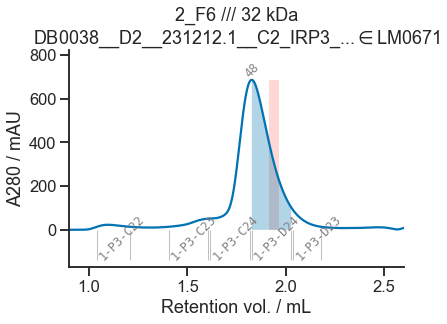

Next best fraction:
['2_F6', ['1-P3-C24']],


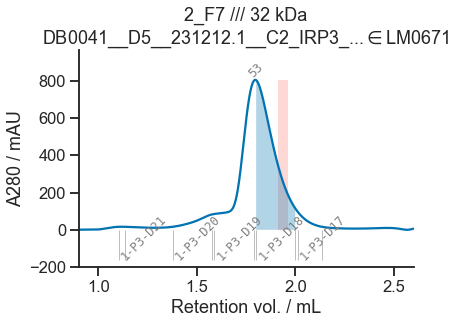

Next best fraction:
['2_F7', ['1-P3-D19']],


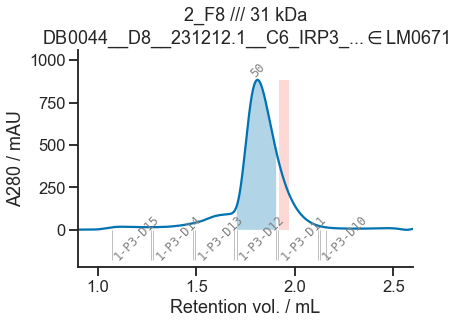

Next best fraction:
['2_F8', ['1-P3-D11']],


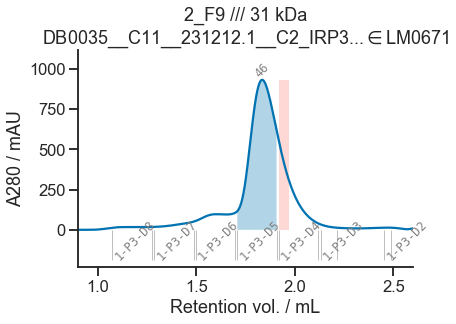

Next best fraction:
['2_F9', ['1-P3-D4']],


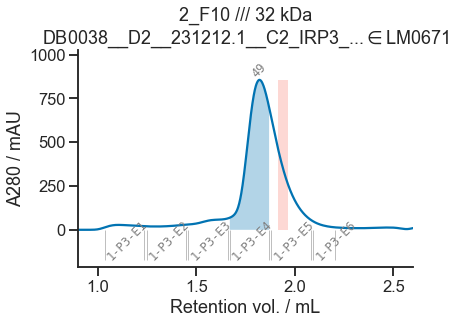

Next best fraction:
['2_F10', ['1-P3-E5']],


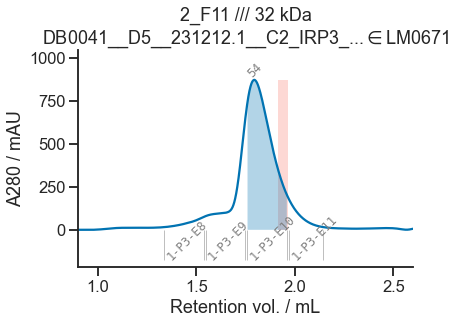

Next best fraction:
['2_F11', ['1-P3-E9']],


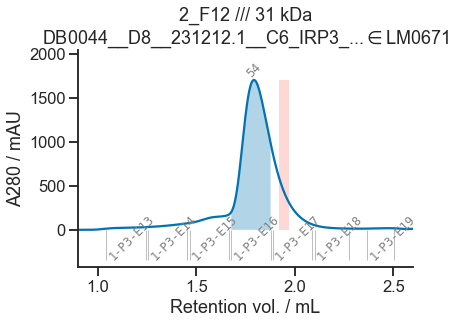

Next best fraction:
['2_F12', ['1-P3-E17']],


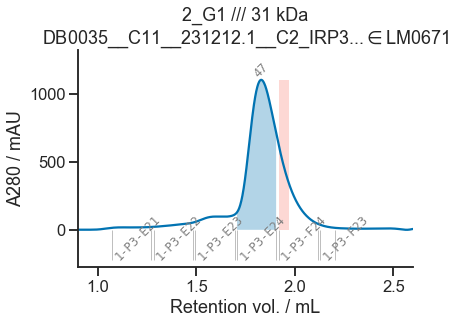

Next best fraction:
['2_G1', ['1-P3-F24']],


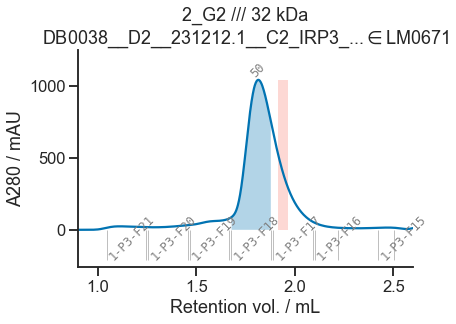

Next best fraction:
['2_G2', ['1-P3-F17']],


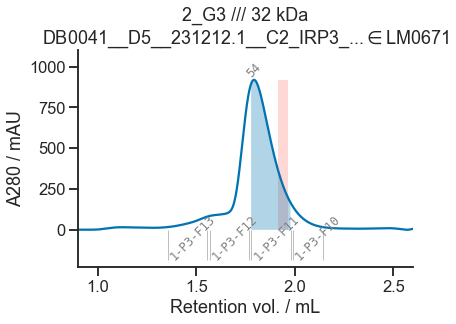

Next best fraction:
['2_G3', ['1-P3-F12']],


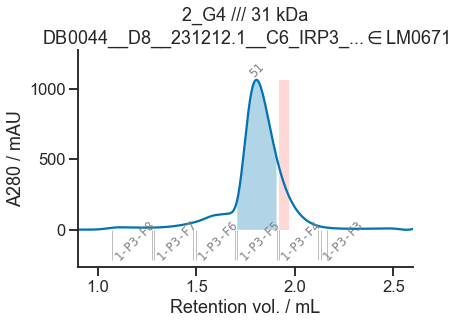

Next best fraction:
['2_G4', ['1-P3-F4']],


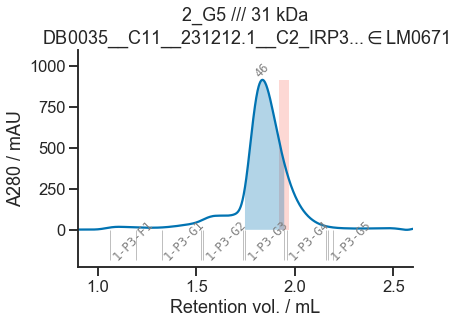

Next best fraction:
['2_G5', ['1-P3-G4']],


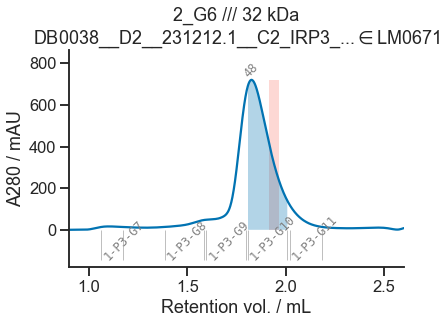

Next best fraction:
['2_G6', ['1-P3-G9']],


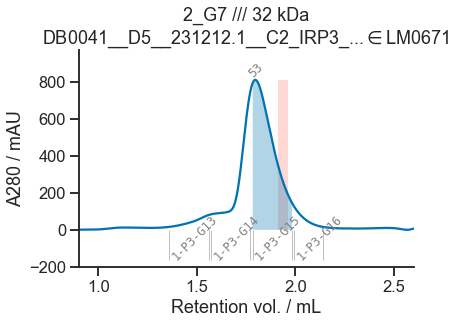

Next best fraction:
['2_G7', ['1-P3-G14']],


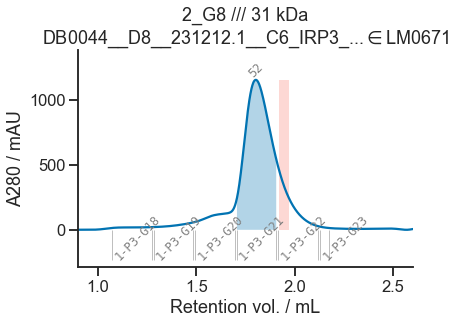

Next best fraction:
['2_G8', ['1-P3-G22']],


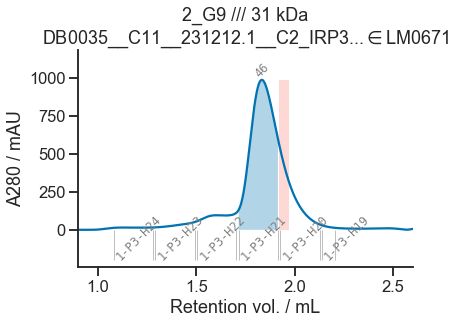

Next best fraction:
['2_G9', ['1-P3-H20']],


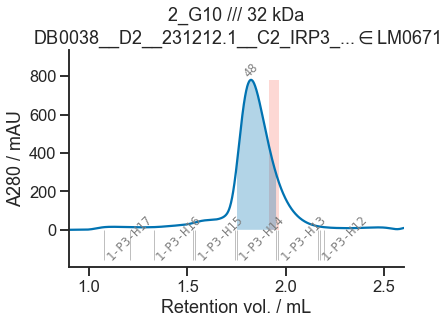

Next best fraction:
['2_G10', ['1-P3-H13']],


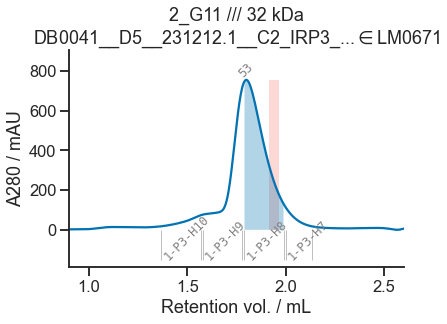

Next best fraction:
['2_G11', ['1-P3-H9']],


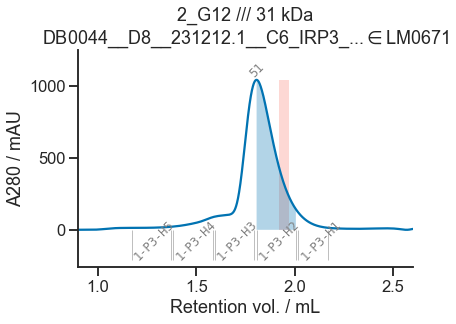

Next best fraction:
['2_G12', ['1-P3-H3']],


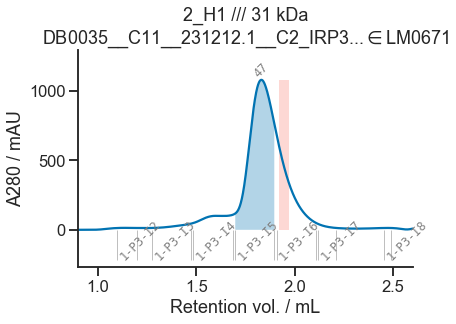

Next best fraction:
['2_H1', ['1-P3-I6']],


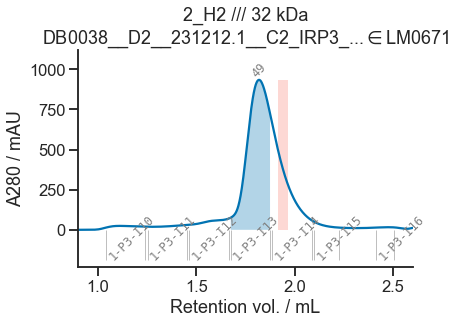

Next best fraction:
['2_H2', ['1-P3-I14']],


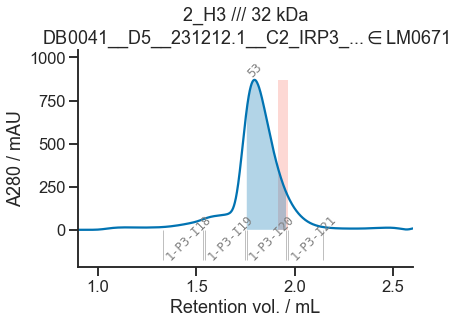

Next best fraction:
['2_H3', ['1-P3-I19']],


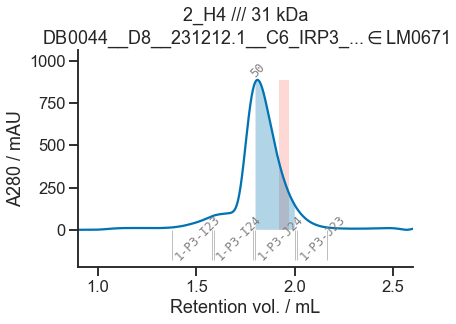

Next best fraction:
['2_H4', ['1-P3-I24']],


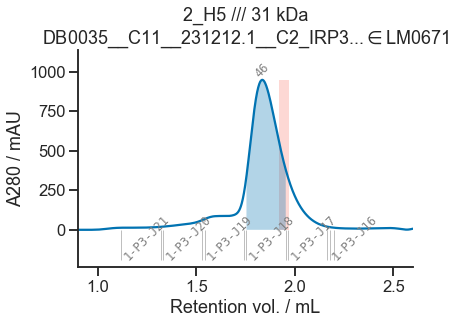

Next best fraction:
['2_H5', ['1-P3-J17']],


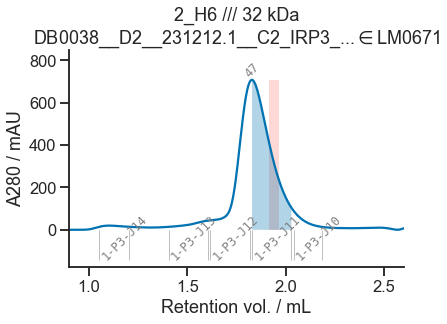

Next best fraction:
['2_H6', ['1-P3-J12']],


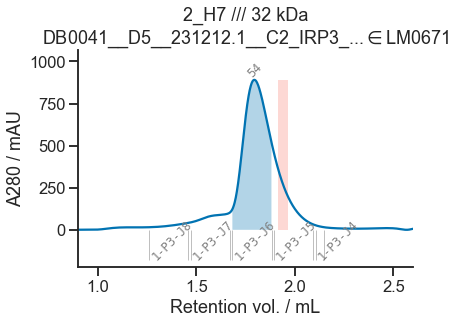

Next best fraction:
['2_H7', ['1-P3-J5']],


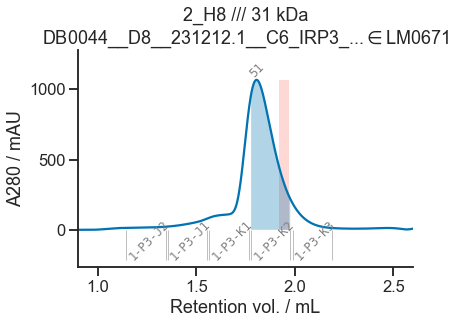

Next best fraction:
['2_H8', ['1-P3-K1']],


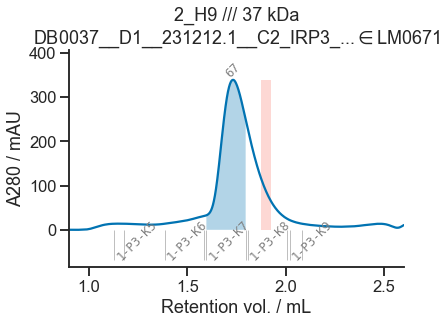

Next best fraction:
['2_H9', ['1-P3-K8']],


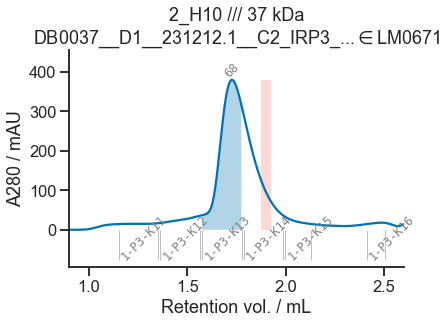

Next best fraction:
['2_H10', ['1-P3-K14']],


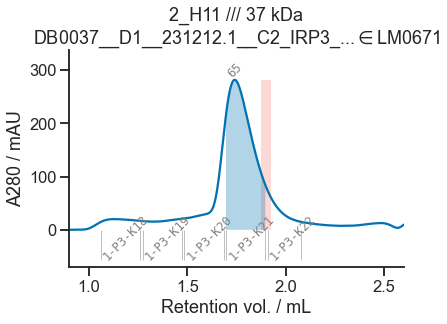

Next best fraction:
['2_H11', ['1-P3-K20']],


In [24]:
pooled_df = pd.DataFrame(
    columns=['pooled_fractions', 'pooled_frac_vol', 'pooled_vol', 'pooled_integral', 'pooled_peak_Abs', 'pooled_peak_vol']
)

for w, r in df.set_index('well_id').iterrows():
    
    select_fractions(
        w, 
        r, 
        pooled_df, 
        manual_edits, 
        Vel2MW, 
        wl, 
        n_fractions=1,
        how='nearest',
        adjacency=0.025,
    )

191


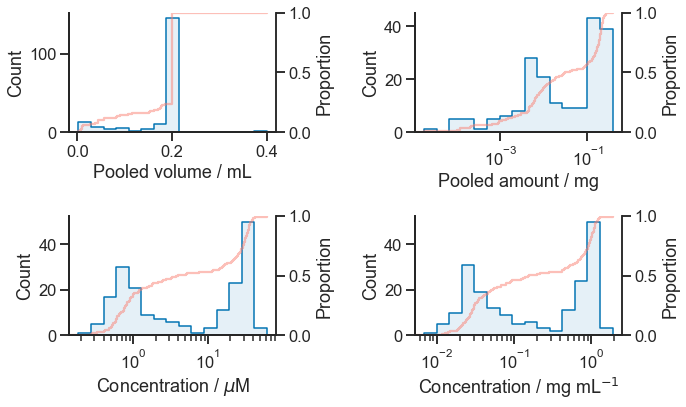

In [25]:
df = int_df.merge(
    pooled_df, 
    left_on='well_id', 
    right_index=True
)

print(len(df))

df['conc_uM'] = 1e3 * df['pooled_integral'] / (df['pooled_vol'] * df['e280'] * df['path_length'])
df['conc_mgmL'] = 1e-3 * df['pooled_integral'] / (df['pooled_vol'] * df['OD280'] * df['path_length'])
df['pooled_mg'] = df['conc_mgmL'] * df['pooled_vol']
df['pooled_peak_estimated_MW'] = df['pooled_peak_vol'].apply(Vel2MW)
df['pooled_peak_agg_state'] = round(df['pooled_peak_estimated_MW'] / df['protomer_MW']).astype(int)
df['pooled_is_main'] = df['main_peak']==df['pooled_peak_vol']

# Plot pooled statistics.
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,6))
ax = ax.reshape(-1)

for i, (k, v) in enumerate({
        'pooled_vol':'Pooled volume / mL',
        'pooled_mg':'Pooled amount / mg',
        'conc_uM':'Concentration / $\mu$M',
        'conc_mgmL':'Concentration / mg mL$^{-1}$',
    }.items()):
    
    sns.histplot(df[k], ax=ax[i], element='step', bins=15, alpha=0.1, log_scale=False if 'vol' in k else True)
    sns.ecdfplot(df[k], ax=ax[i].twinx(), alpha=0.5, color='salmon')
    ax[i].spines['right'].set_visible(True)
    ax[i].set(xlabel=v)

plt.tight_layout()
plt.savefig('pooled_results.png', dpi=300)
plt.show()

## Generate OT-2 script

In [26]:
find_opt_concentration(df)

Choosing 4.64 uM will maximise the number of wells that are normalised correctly.


49.2% of wells will have the desired concentration.


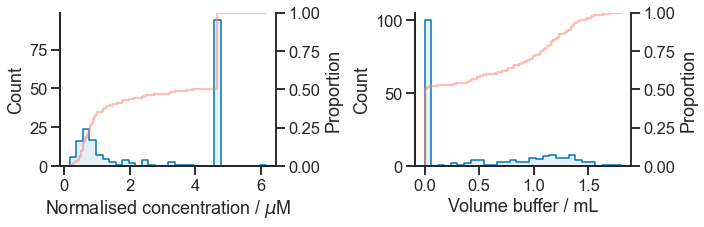

In [27]:
desired_conc = 4.64 # uM

df['buffer_vol'] = df.pooled_vol * (df.conc_uM - desired_conc) / desired_conc 
df['buffer_vol'] = df.apply(correct_buffer, args=(2,), axis=1)
df['normed_conc_uM'] = df.conc_uM * df.pooled_vol / (df.pooled_vol + df.buffer_vol)

frac_correct = np.isclose(df.normed_conc_uM.to_list(), desired_conc, atol=0.05).sum() / len(df)
print(f'{100 * frac_correct:.1f}% of wells will have the desired concentration.')

# Plot normalization statistics.
fig, ax = plt.subplots(ncols=2, figsize=(10,3.5))
ax = ax.reshape(-1)

for i, (k, v) in enumerate({
        'normed_conc_uM':'Normalised concentration / $\mu$M',
        'buffer_vol':'Volume buffer / mL',
    }.items()):
    
    sns.histplot(df[k], ax=ax[i], element='step', alpha=0.1, bins=30)
    sns.ecdfplot(df[k], ax=ax[i].twinx(), alpha=0.5, color='salmon')
    ax[i].spines['right'].set_visible(True)
    ax[i].set(xlabel=v)

plt.tight_layout()
plt.savefig('normalization_results.png', dpi=300)
plt.show()

In [28]:
gen_ot2_script(
    df.dropna(),
    sec_instrument,
    normalize=True,
    template='/home/bwicky/ot2/templates/SEC_pool_and_norm_v3.py'
)

240304_sec_pool_and_norm.py contains transfers from 192 fractions to 191 destination wells


## Save data to disk

The following two files will be generated:
- `.csv` file containing only the scalar entries of the dataframe.
- `.h5` file containing everything, including arrays (i.e. SEC traces, etc...).

In [29]:
def is_scalar(column):
    return all(isinstance(entry, (int, float, str)) for entry in column)

df[[col for col in df.columns if is_scalar(df[col])]].to_csv(f'{today}_expdata_df.csv')
df.to_hdf(f'{today}_expdata_df.h5', key='df', complevel=9)

<ipython-input-29-7765899a11b7>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['w96', 'Name', 'eblock', 'Source Well', 'Vector', 'Destination Well',
       'plasmid_seq', 'ORF', 'exp_prod', 'sec_instrument', 'sec_column',
       'sec_buffer', 'category', 'vol280', 'vol260', 'vol230', 'vol205',
       'vol488', 'vol460', 'A280', 'A260', 'A230', 'A205', 'A488', 'A460',
       'trace_id', 'fractions', 'frac_vol', 'frac_start_stop', 'vol', 'Abs',
       'vol_clipped', 'Abs_corr', 'Abs_norm', 'peaks', 'peak_heights',
       'light_idx', 'vol_light', 'Abs_light', 'Abs_norm_light', 'well_id',
       'pooled_fractions', 'pooled_frac_vol', 'pooled_vol', 'pooled_integral',
       'pooled_peak_Abs', 'pooled_peak_vol', 'conc_uM', 'conc_mgmL',
       'pooled_mg', 'normed_conc_uM'],
      dtype='object')]

  df.to_hdf(f'{today}_expdata_df.h5', key='df', co

## Legacy plots

In [ ]:
sns.boxplot(
    data=df, 
    x='category', 
    y='tot_yield', 
    fliersize=0,
    color='white',
)

sns.swarmplot(
    data=df, 
    x='category', 
    y='tot_yield', 
    alpha=0.8, 
    edgecolor='k', 
    linewidth=1, 
    size=6,
)
plt.ylabel('Tot. yield / mg')
plt.tight_layout()
plt.savefig('yields_by_category.png', dpi=300)
plt.show()

In [ ]:
cat2col = {cat:'C'+str(i) for i, cat in enumerate(df.category.unique())}

g = sns.clustermap(
    df['Abs_norm_light'].to_list(), 
    method='average',
    cmap='bone_r', 
    col_cluster=False,
    row_colors=[cat2col[cat] for cat in df.category.to_list()], 
    tree_kws={'lw':1, 'color':'grey'},
)

g.cax.remove() 
plt.yticks([])

# X-axis
nlabels = 7
vmin, vmax = np.min(df.vol_light.min()), np.max(df.vol_light.max())
vol_labels = np.linspace(vmin, vmax, nlabels, dtype=float)
mw_labels = [Vel2MW(v) for v in vol_labels]
lbls = [f'{v:.2f}\n[{mw/1000:.0f}]' for v, mw in list(zip(vol_labels, mw_labels))]
plt.xticks(ticks=np.linspace(0, 100, nlabels), 
           labels=lbls, 
           rotation=0)

# Legend
handles = [Patch(edgecolor='k', facecolor=v) for v in cat2col.values()]
plt.legend(
    handles, 
    cat2col.keys(), 
    title='category', 
    ncol=int(len(cat2col)/2),
    bbox_to_anchor=(0.55, 0.92), 
    bbox_transform=plt.gcf().transFigure, 
    loc='upper center',
)

plt.xlabel('Retention vol. / mL\n[MW / kDa]')
plt.savefig('clustered_sec_traces.png', dpi=300)
plt.show()